# **Tujuan dan Latar Belakang**

## Tujuan
1. Mengukur elastisitas harga listrik (price elasticity of demand) pada sektor residential dan industrial di Jepang selama 1990–2015.
2. Menganalisis perbedaan sensitivitas harga antar wilayah (10 region) untuk mengetahui daerah yang paling responsif terhadap perubahan tarif.
3. Menyediakan dasar analisis bagi pembuat kebijakan dalam menetapkan strategi harga listrik dan program efisiensi energi.


## Latar Belakang

Konsumsi listrik memainkan peran penting dalam mendukung pembangunan ekonomi dan kehidupan masyarakat. Di Jepang, pola konsumsi listrik sektor residensial dan industri sangat bervariasi antar wilayah, terutama setelah peristiwa Gempa Besar Jepang Timur tahun 2011 yang memicu perubahan kebijakan energi dan kenaikan harga listrik secara nasional.

Dataset Regional Data on Electricity Consumption and Electricity Prices in Japan menyajikan data historis tahun 1990–2015 tentang konsumsi dan harga listrik per wilayah. Analisis terhadap data ini memungkinkan pengukuran elastisitas harga listrik serta pemahaman sensitivitas permintaan listrik, yang penting bagi perumusan kebijakan energi yang lebih tepat sasaran.

Paper reference: [Regional data on electricity consumption and electricity prices in Japan](https://www.sciencedirect.com/science/article/pii/S235234092300567X)

#Mengumpulkan Data

## Load Library

In [ ]:
# Import Library
!pip install shap
import shap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## Load Dataset

In [ ]:
# Load Dataset
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/Sertifikasi Data Sains/(Dataset Fix) regional-data-on-the-electricity-consumption-in-Japan.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# cek nama kolom
df.columns

Index(['Region', 'Year', 'Con. Res', 'Con. Ind', 'El. Res', 'El. Ind',
       'N. Price. Res', 'N. Price. Ind', 'R. Price. Res', 'R. Price. Ind'],
      dtype='object')

# Menelaah Data

## Mengecek Value

In [ ]:
df.head()

,Region,Year,Con. Res,Con. Ind,El. Res,El. Ind,N. Price. Res,N. Price. Ind,R. Price. Res,R. Price. Ind
0,Hokkaido,1990,7048924000,13405991000,"3365,104129","45925,55506","28,24601315","20,10146061","143,1465422","134,2001901"
1,Tohoku,1990,14953172000,38291489000,"4144,630502","56332,96652","26,07272892","18,1140514","131,3220557","120,5362583"
2,Tokyo,1990,60194455000,159747824000,"4387,255336","79980,72626","24,83781936","17,25248539","124,027397","115,5324204"
3,Chubu,1990,21664803000,78130377000,"4309,14139","81814,65452","23,56241135","16,45129653","118,1013715","108,5604408"
4,Hokuriku,1990,4506926000,16741940000,"5048,843631","80571,83008","24,81691512","16,10978178","141,8098812","118,9838426"


In [ ]:
df.tail()

,Region,Year,Con. Res,Con. Ind,El. Res,El. Ind,N. Price. Res,N. Price. Ind,R. Price. Res,R. Price. Ind
255,Kansai,2015,44053066000,83463091000,"4798,265861","87011,50728","24,14828516","18,33422393","118,3594824","135,2817337"
256,Chugoku,2015,17709999000,39008849000,"5478,282214","109880,9865","21,62495887","15,06699159","103,2831483","113,8101818"
257,Shikoku,2015,8931735000,16822868000,"5121,102297","85452,96063","22,41042754","17,01362693","107,0582135","122,9788156"
258,Kyusyu,2015,28100257000,51109403000,"4826,998686","83516,05387","21,86044064","16,11488203","110,9805871","121,7337387"
259,Okinawa,2015,2953315000,4695358000,"4881,71412","67431,03745","24,64383244","19,01005206","101,7369543","106,2694325"


## Melihat Dimensi Data

In [ ]:
df.shape

(260, 10)

## Melihat Informasi Dataset

In [ ]:
# Melihat Informasi Dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Region         260 non-null    object
 1   Year           260 non-null    int64 
 2   Con. Res       260 non-null    int64 
 3   Con. Ind       260 non-null    int64 
 4   El. Res        260 non-null    object
 5   El. Ind        260 non-null    object
 6   N. Price. Res  260 non-null    object
 7   N. Price. Ind  260 non-null    object
 8   R. Price. Res  260 non-null    object
 9   R. Price. Ind  260 non-null    object
dtypes: int64(3), object(7)
memory usage: 20.4+ KB


In [ ]:
for col in df.select_dtypes(include='object').columns:
    if col != 'Region':
        # 1. Ganti koma jadi titik
        df[col] = df[col].str.replace(',', '.', regex=False)

        # 2. Konversi ke numerik (float64 jika ada desimal, Int64 jika bulat)
        df[col] = pd.to_numeric(df[col], errors='coerce')

- Cek kembali type data

In [ ]:
# Melihat Informasi Dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Region         260 non-null    object 
 1   Year           260 non-null    int64  
 2   Con. Res       260 non-null    int64  
 3   Con. Ind       260 non-null    int64  
 4   El. Res        260 non-null    float64
 5   El. Ind        260 non-null    float64
 6   N. Price. Res  260 non-null    float64
 7   N. Price. Ind  260 non-null    float64
 8   R. Price. Res  260 non-null    float64
 9   R. Price. Ind  260 non-null    float64
dtypes: float64(6), int64(3), object(1)
memory usage: 20.4+ KB


## Melihat Deskripsi Statistik

In [ ]:
# Melihat Deskripsi statistik
df.describe()

,Year,Con. Res,Con. Ind,El. Res,El. Ind,N. Price. Res,N. Price. Ind,R. Price. Res,R. Price. Ind
count,260.000000,2.600000e+02,2.600000e+02,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000
mean,2002.500000,2.527106e+10,5.596776e+10,5284.461074,84338.478299,22.920940,15.913938,111.428034,113.256455
std,7.514465,2.378662e+10,5.103125e+10,727.246907,18900.636441,2.092497,2.054282,10.972212,10.739414
min,1990.000000,1.795494e+09,2.929487e+09,3365.104129,40687.884550,18.317184,12.343343,93.559808,96.144016
25%,1996.000000,8.592269e+09,1.810774e+10,4854.877745,70361.875012,21.253043,14.055399,102.739564,104.050482
50%,2002.500000,1.851042e+10,4.033116e+10,5311.039284,86552.015255,22.847274,15.744434,108.378509,112.644526
75%,2009.000000,3.244927e+10,8.852728e+10,5605.950523,97519.128708,24.625116,17.343351,118.392468,120.562490
max,2015.000000,1.034221e+11,1.997966e+11,7836.842543,121533.417400,28.308689,20.835472,143.146542,143.429278


## Melihat persebaran data

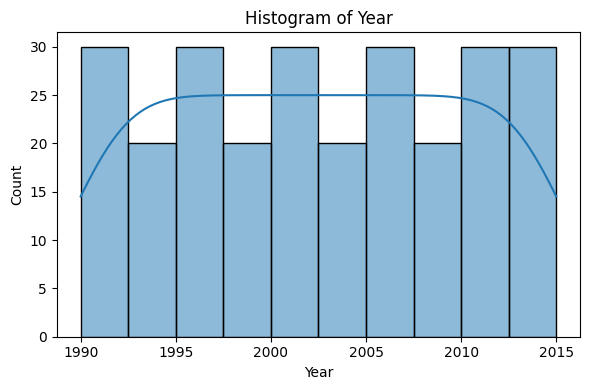

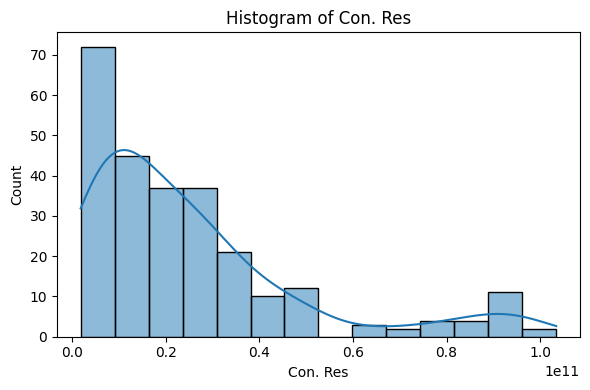

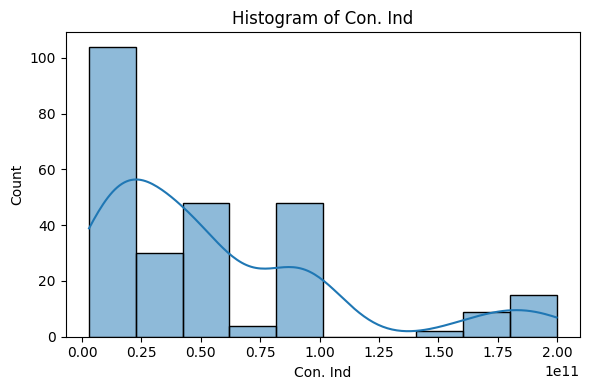

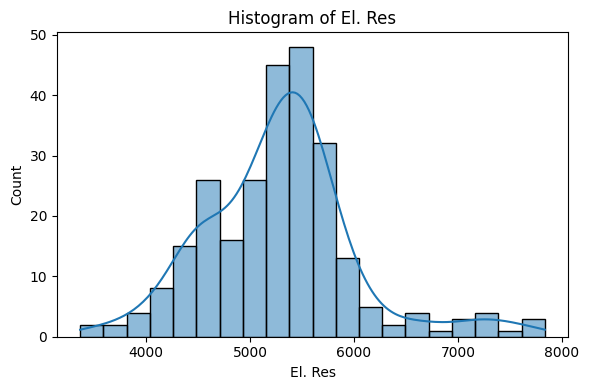

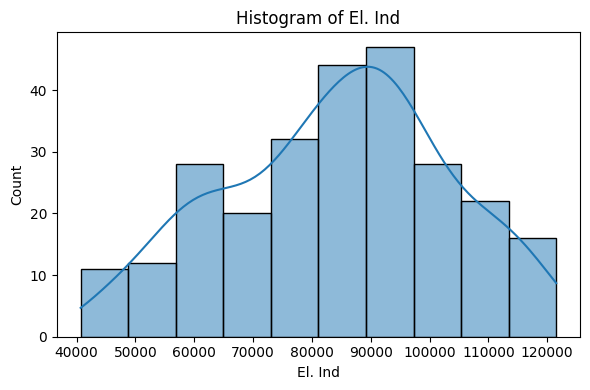

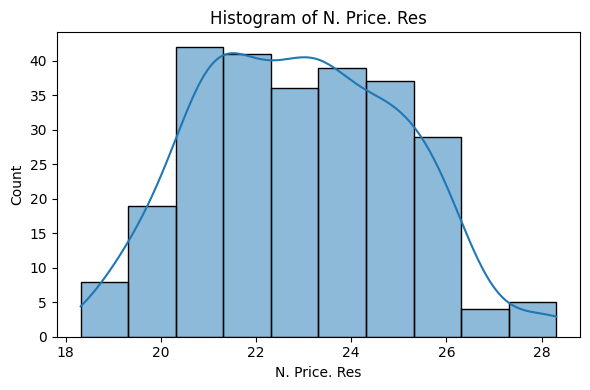

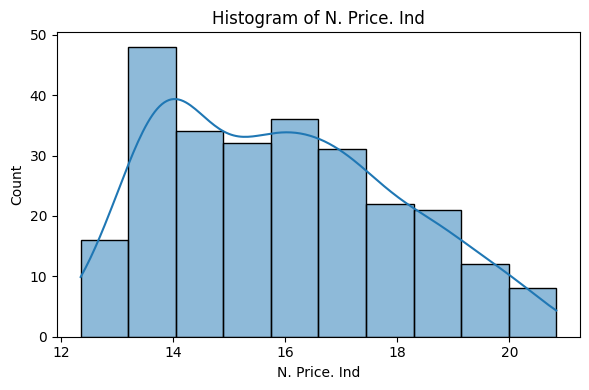

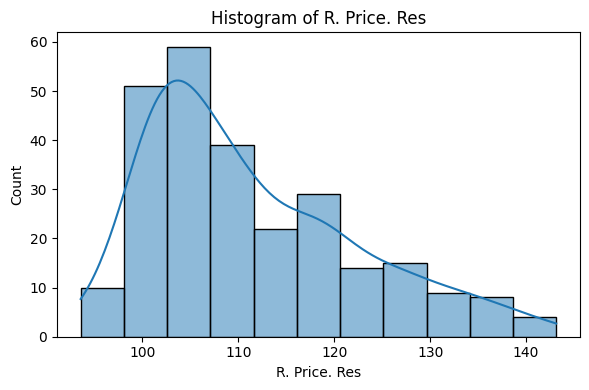

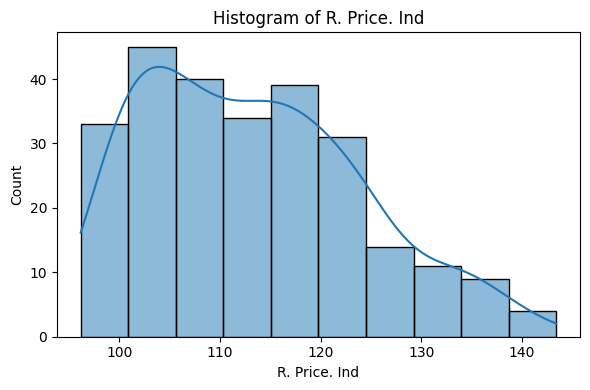

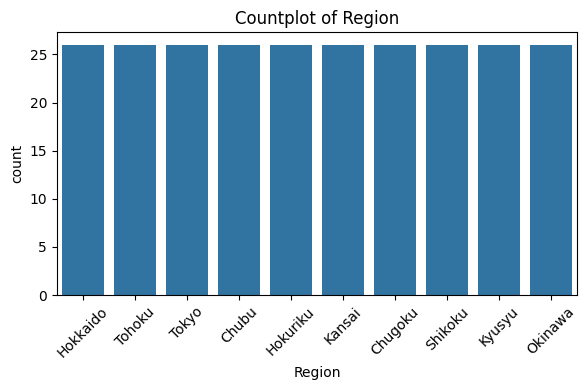

In [ ]:
# Ambil kolom numerik dan kategorikal
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns

# Plot histogram untuk kolom numerik
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f'Histogram of {col}')
    plt.tight_layout()
    plt.show()

# Plot countplot untuk kolom kategorikal
for col in cat_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x=col)
    plt.title(f'Countplot of {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
# membuat fungsi untuk melakukan observasi pada dataset
def grab_col_names(dataframe, cat_th = 10, car_th = 20): #  memisahkan kolom dalam dataset berdasarkan tipe dan karakteristiknya.

    cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["category", "object", "bool"]] # kolom kategorikal (tipe "category", "object", "bool", atau numerik dengan unique values < cat_th).
    num_but_cat = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["int64", "float64"] and dataframe[col].nunique() < cat_th] # kolom numerik yang bertindak seperti kategorikal (berdasarkan jumlah unique values).
    cat_but_car = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["category", "object"] and dataframe[col].nunique() > car_th] # kolom kategorikal dengan unique values > car_th (high cardinality).

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # kolom numerik murni (int64, float64) yang bukan kategorikal.
    num_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["int64", "float64"]]
    num_cols = [col for col in num_cols if col not in cat_cols]

    print(f"Jumlah observasi: {dataframe.shape[0]}")
    print(f"Jumlah variabel: {dataframe.shape[1]}")
    print(f"Kolom kategorikal: {len(cat_cols)}")
    print(f"Kolom Numerik: {len(num_cols)}")
    print(f"Kategori tapi kardinal: {len(cat_but_car)}")
    print(f"Numerik tapi kategorikal: {len(num_but_cat)}")

    # mengembalikan daftar kolom yang dikelompokkan berdasarkan tipe (cat_cols, num_cols, cat_but_car).
    return cat_cols, num_cols, cat_but_car

In [ ]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Jumlah observasi: 260
Jumlah variabel: 10
Kolom kategorikal: 1
Kolom Numerik: 9
Kategori tapi kardinal: 0
Numerik tapi kategorikal: 0


# Memvalidasi Data

## Cek missing values

In [ ]:
# Melihat Nilai null / missing value
df.isnull().sum()

,0
Region,0
Year,0
Con. Res,0
Con. Ind,0
El. Res,0
El. Ind,0
N. Price. Res,0
N. Price. Ind,0
R. Price. Res,0
R. Price. Ind,0


## Memeriksa duplikat data

In [ ]:
# Melihat Data duplikat
df.duplicated().sum()

np.int64(0)

In [ ]:
print("Duplikat:", df.duplicated().sum())

Duplikat: 0


## Cek nilai unique

In [ ]:
df.nunique()

,0
Region,10
Year,26
Con. Res,260
Con. Ind,260
El. Res,260
El. Ind,260
N. Price. Res,260
N. Price. Ind,260
R. Price. Res,251
R. Price. Ind,251


In [ ]:
for col in df.columns:
 print(f'{col}')
 print(f'Jumlah nilai yang unik: {df[col].nunique()}')
 print(f'Nilai yang paling sering muncul (modus): {df[col].mode().values[0]}')
 print(f'{df[col].unique()}\n')

Region
Jumlah nilai yang unik: 10
Nilai yang paling sering muncul (modus): Chubu
['Hokkaido' 'Tohoku' 'Tokyo' 'Chubu' 'Hokuriku' 'Kansai' 'Chugoku'
 'Shikoku' 'Kyusyu' 'Okinawa']

Year
Jumlah nilai yang unik: 26
Nilai yang paling sering muncul (modus): 1990
[1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003
 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015]

Con. Res
Jumlah nilai yang unik: 260
Nilai yang paling sering muncul (modus): 1795494000
[  7048924000  14953172000  60194455000  21664803000   4506926000
  32422262000  11368795000   6087784000  17376399000   1795494000
   7451627000  15711144000  63475970000  22744528000   4684586000
  33410121000  11684494000   6323412000  17900879000   1939592000
   7816328000  16613702000  66100197000  23616003000   4853566000
  34069898000  12061624000   6481489000  18572797000   1949943000
   8163942000  17299975000  67380931000  24421771000   5027122000
  34968962000  12443758000   6718366000  19181150000   20

# Menentukan Objek Data

In [ ]:
# Ambil subset kolom yang menjadi objek analisis
df_objek = df[['Region', 'Year',
               'Con. Res', 'Con. Ind',
               'R. Price. Res', 'R. Price. Ind',
               'El. Res', 'El. Ind']]

# Cek struktur data
df_objek.info()
df_objek.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Region         260 non-null    object 
 1   Year           260 non-null    int64  
 2   Con. Res       260 non-null    int64  
 3   Con. Ind       260 non-null    int64  
 4   R. Price. Res  260 non-null    float64
 5   R. Price. Ind  260 non-null    float64
 6   El. Res        260 non-null    float64
 7   El. Ind        260 non-null    float64
dtypes: float64(4), int64(3), object(1)
memory usage: 16.4+ KB


,Region,Year,Con. Res,Con. Ind,R. Price. Res,R. Price. Ind,El. Res,El. Ind
0,Hokkaido,1990,7048924000,13405991000,143.146542,134.200190,3365.104129,45925.55506
1,Tohoku,1990,14953172000,38291489000,131.322056,120.536258,4144.630502,56332.96652
2,Tokyo,1990,60194455000,159747824000,124.027397,115.532420,4387.255336,79980.72626
3,Chubu,1990,21664803000,78130377000,118.101371,108.560441,4309.141390,81814.65452
4,Hokuriku,1990,4506926000,16741940000,141.809881,118.983843,5048.843631,80571.83008


# Membersihkan Data

## Handling Missing Values

In [ ]:
# Dikarenakan tidak ada missing values maka langkah ini dilewatin saja

## Handling Duplikat Data

In [ ]:
# Dikarenakan tidak ada duplikat data maka langkah ini dilewatin saja

Dikarenakan tidak ada duplikat data maka langkah ini dilewatin saja

## Visualisasi data berdasarkan tujuan penelitian

## Tujuan 1: Mengukur Elastisitas Harga Listrik

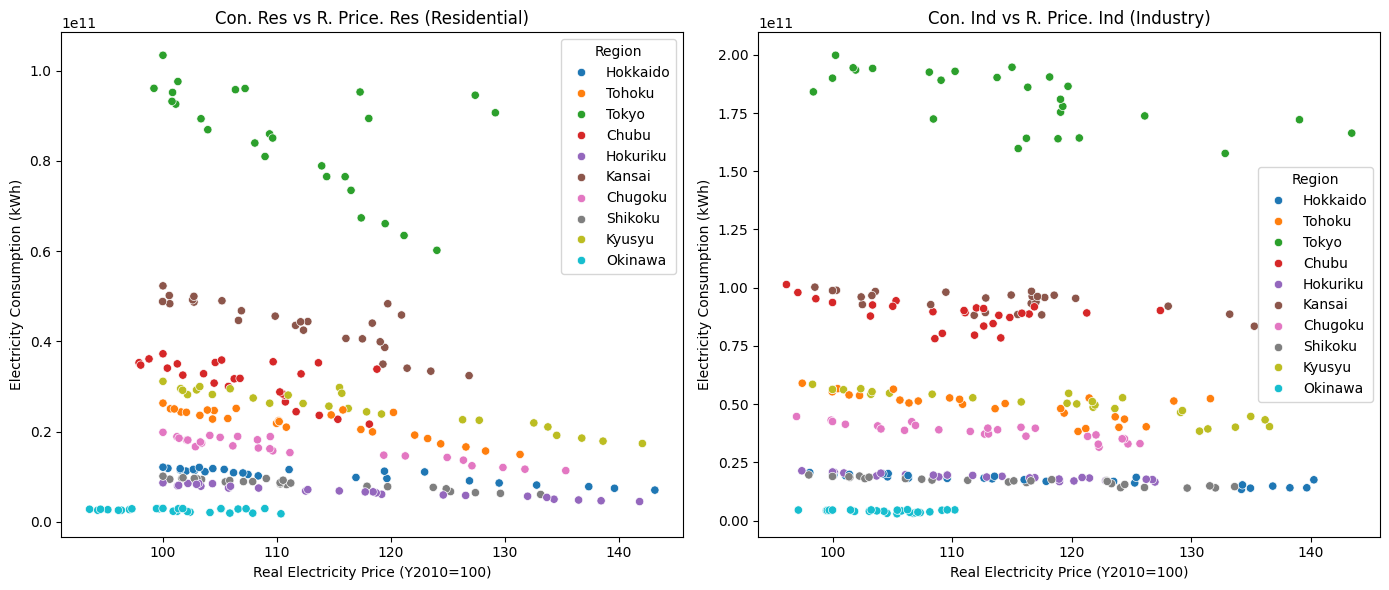

In [ ]:
plt.figure(figsize=(14, 6))

# Plot sektor residensial
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='R. Price. Res', y='Con. Res', hue='Region')
plt.title('Con. Res vs R. Price. Res (Residential)')
plt.xlabel('Real Electricity Price (Y2010=100)')
plt.ylabel('Electricity Consumption (kWh)')

# Plot sektor industri
plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='R. Price. Ind', y='Con. Ind', hue='Region')
plt.title('Con. Ind vs R. Price. Ind (Industry)')
plt.xlabel('Real Electricity Price (Y2010=100)')
plt.ylabel('Electricity Consumption (kWh)')

plt.tight_layout()
plt.show()

### Kesimpulan Tujuan 1

1. Penggunaan listrik meningkat seiring dengan peningkatan harga di sejumlah wilayah misalnya di Tokyo dan Kansai.
2. Penggunaan listrik lebih stabil di beberapa wilayah, diantaranya Okinawa, Shikoku, dan Hokkaido.
3. Penggunaan listrik dalam bidang industri lebih besar dibandingkan dengan sektor residensial.
4. Beberapa wilayah menunjukkan penurunan konsumsi ketika harga naik, mengindikasikan adanya sensitivitas harga di sektor industri.

4. Dalam sektor industri, konsumsi secara umum lebih tinggi dan menunjukkan dinamika harga yang berbeda dibanding sektor residensial. Oleh karena itu, penyusunan kebijakan tarif listrik sebaiknya mempertimbangkan perbedaan elastisitas harga antar wilayah dan sektor.


## Tujuan 2: Mengukur Sensitivitas Antar Wilayah

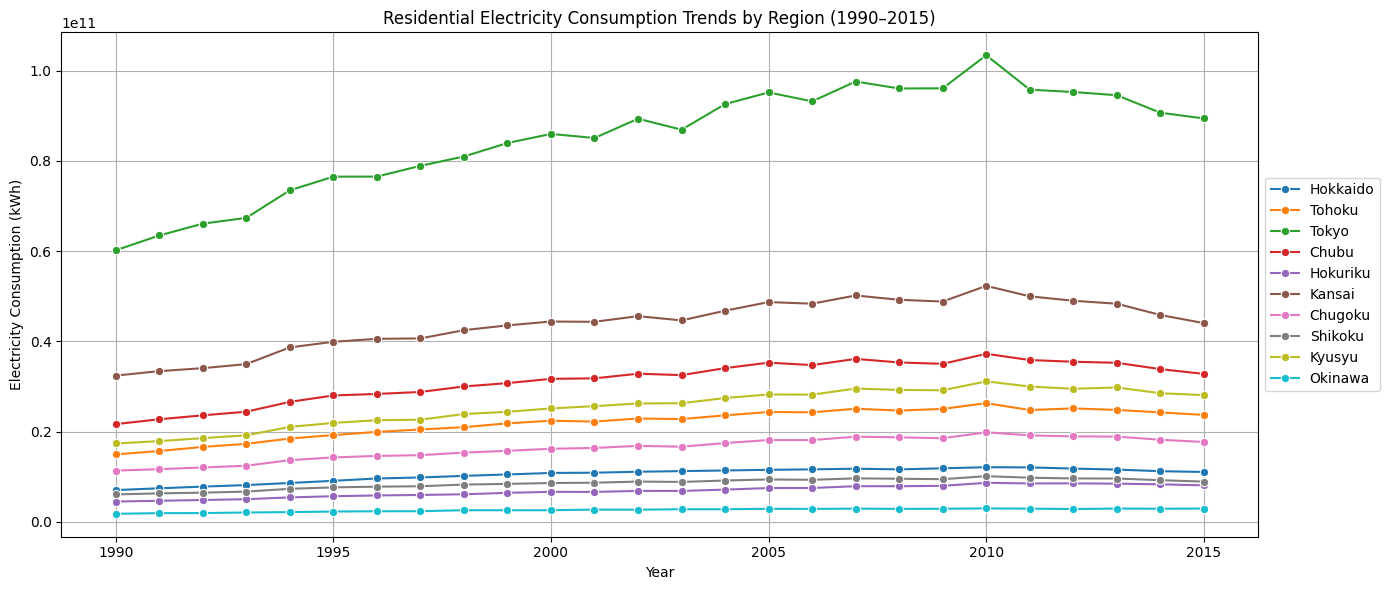

In [ ]:
plt.figure(figsize=(14, 6))

# Konsumsi residensial per wilayah
sns.lineplot(data=df, x='Year', y='Con. Res', hue='Region', marker='o')
plt.title('Residential Electricity Consumption Trends by Region (1990–2015)')
plt.xlabel('Year')
plt.ylabel('Electricity Consumption (kWh)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()

### Kesimpulan Tujuan 2

1. Pada wilayah Tokyo menunjukkan penggunaan listrik yang paling tinggi diantara wilayah lainnya dengan tren yang dinamis.
2. Pada wilayah Kansai dan Chubu menunjukkan tren penggunaan listrik yang tinggi dengan jumlah yang stabil.
3. Pada wilayah Okinawa, Shikoku, dan Hokkaido menunjukkan tren penggunaan listrik yang rendah dengan jumlah yang stabil.
4. Sebagian besar wilayah di Jepang menunjukkan penurunan penggunaan listrik pasca tahun 2010, penurunan ini disebabkan oleh perubahan kebijakan energi pasca Gempa Bumi Besar Jepang Timur tahun 2011, terhadap konsumsi listrik regional.


## Tujuan 3: Memberi dasar pengambilan kebijakan

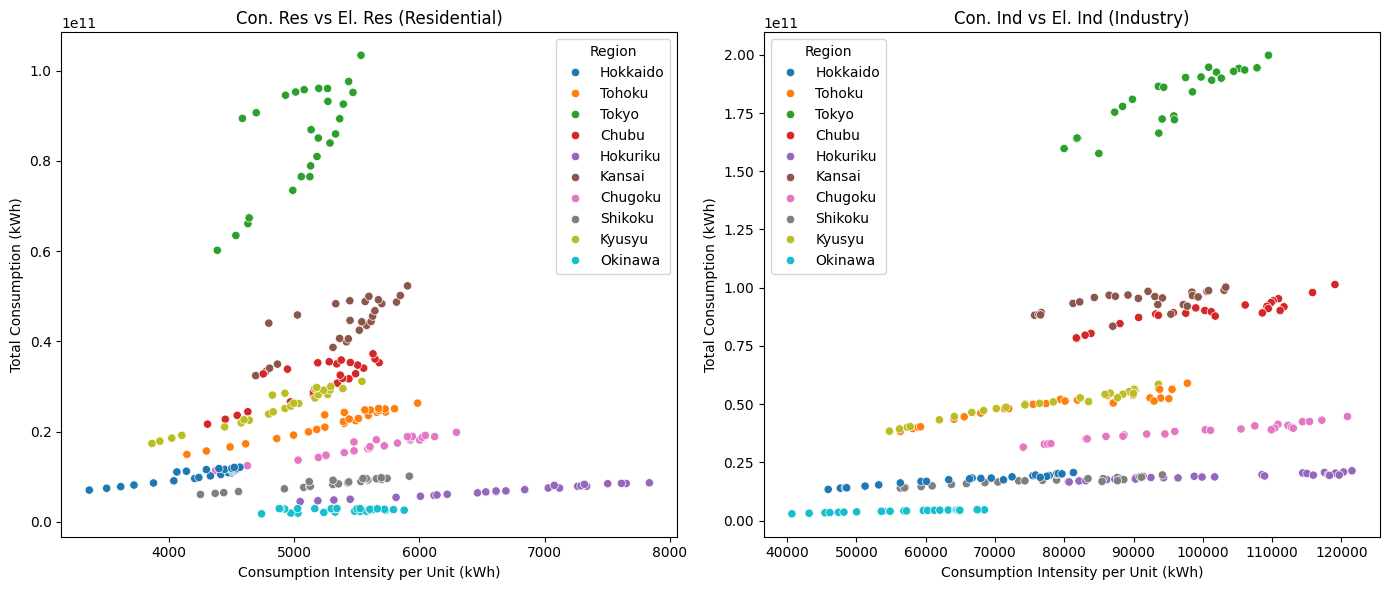

In [ ]:
plt.figure(figsize=(14, 6))

# EI vs konsumsi di sektor residensial
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='El. Res', y='Con. Res', hue='Region')
plt.title('Con. Res vs El. Res (Residential)')
plt.xlabel('Consumption Intensity per Unit (kWh)')
plt.ylabel('Total Consumption (kWh)')

# EI vs konsumsi di sektor industri
plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='El. Ind', y='Con. Ind', hue='Region')
plt.title('Con. Ind vs El. Ind (Industry)')
plt.xlabel('Consumption Intensity per Unit (kWh)')
plt.ylabel('Total Consumption (kWh)')

plt.tight_layout()
plt.show()

### Kesimpulan Tujuan 3

1. Pada wilayah Tokyo menunjukkan jumlah penggunaan listrik yang paling tinggi.
2. Intensitas jumlah penggunaan listrik meningkat pada sektor residensial dan industri, hal ini menunjukkan efisiensi energi yang rendah (intensitas tinggi) yang berkontribusi pada konsumsi yang lebih besar.
3. Pada sektor industri, penggunaan listrik tetap tinggi.
4. Efisiensi energi perlu ditingkatkan, khususnya di wilayah berintensitas tinggi seperti Tokyo dan Kansai, karena intensitas yang tinggi berkorelasi dengan konsumsi total yang besar.

# Mengkonstruksi Data

## Cek Outlier

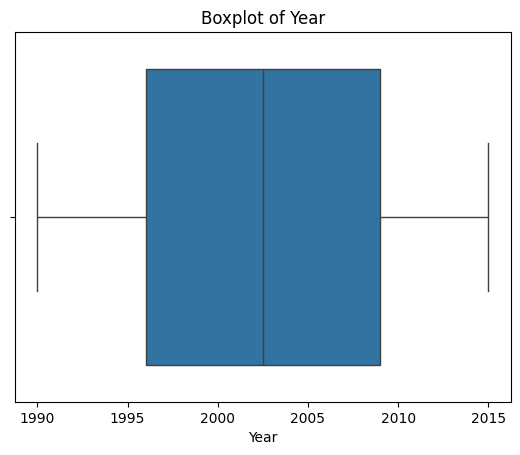

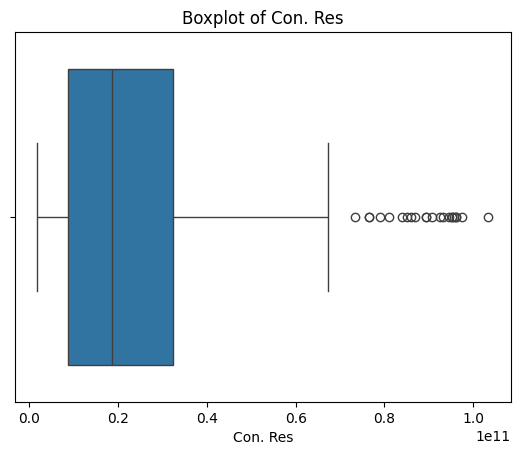

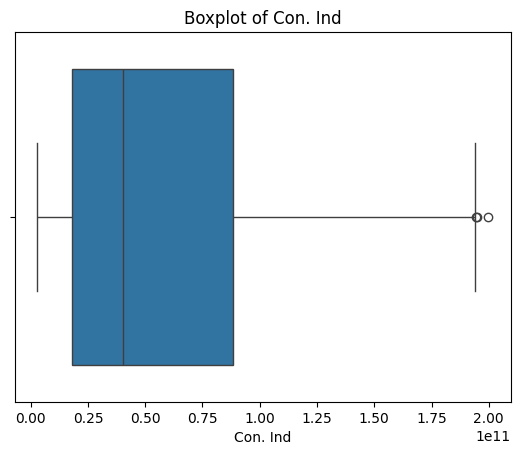

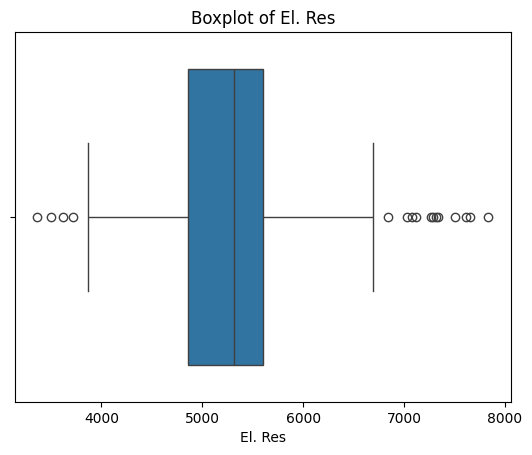

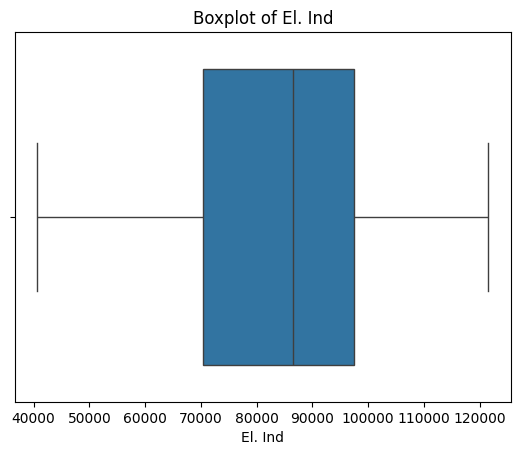

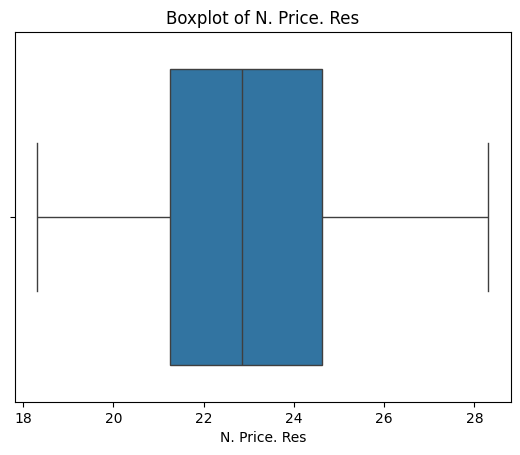

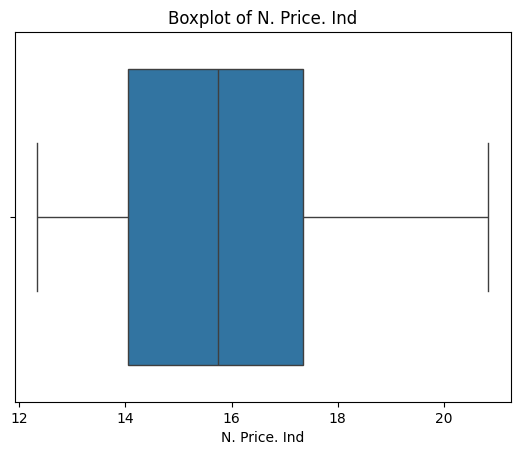

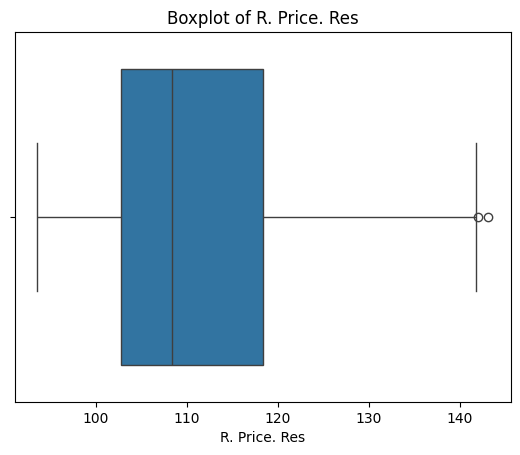

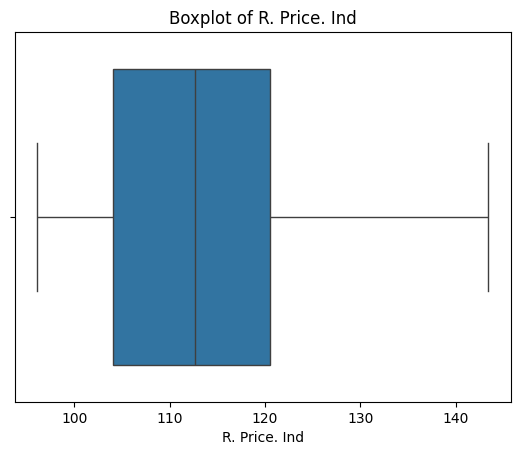

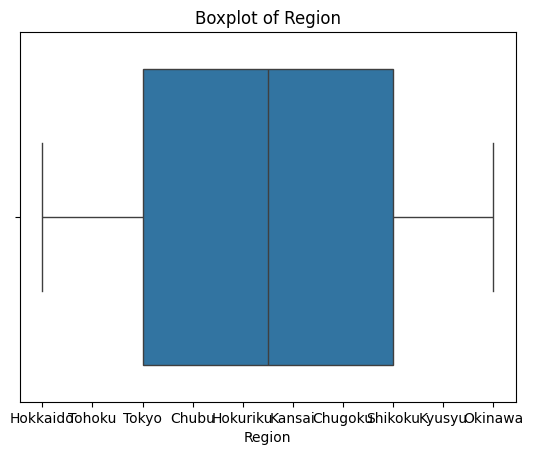

In [ ]:
# cek outlier dengan visualisasi
for col in num_cols:
    boxplot = sns.boxplot(data=df, x=col)
    plt.title(f'Boxplot of {col}')
    plt.show()

for col in cat_cols:
    boxplot = sns.boxplot(data=df, x=col)
    plt.title(f'Boxplot of {col}')
    plt.show()

## Mengubah kolom kategorikal menjadi numerik

In [ ]:
from sklearn.preprocessing import LabelEncoder
enc_cols = ['Region']
for col in enc_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

In [ ]:
from sklearn.preprocessing import LabelEncoder
df_test = df.copy()
# Inisialisasi encoder
le = LabelEncoder()

# Fit encoder dan transform
df_test['Region_encoded'] = le.fit_transform(df['Region'])

# Tampilkan mapping
mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(mapping)


{'Chubu': np.int64(0), 'Chugoku': np.int64(1), 'Hokkaido': np.int64(2), 'Hokuriku': np.int64(3), 'Kansai': np.int64(4), 'Kyusyu': np.int64(5), 'Okinawa': np.int64(6), 'Shikoku': np.int64(7), 'Tohoku': np.int64(8), 'Tokyo': np.int64(9)}


In [ ]:
df.head()

,Region,Year,Con. Res,Con. Ind,El. Res,El. Ind,N. Price. Res,N. Price. Ind,R. Price. Res,R. Price. Ind
0,2,1990,7048924000,13405991000,3365.104129,45925.55506,28.246013,20.101461,143.146542,134.200190
1,8,1990,14953172000,38291489000,4144.630502,56332.96652,26.072729,18.114051,131.322056,120.536258
2,9,1990,60194455000,159747824000,4387.255336,79980.72626,24.837819,17.252485,124.027397,115.532420
3,0,1990,21664803000,78130377000,4309.141390,81814.65452,23.562411,16.451297,118.101371,108.560441
4,3,1990,4506926000,16741940000,5048.843631,80571.83008,24.816915,16.109782,141.809881,118.983843


## Heatmap Correlation

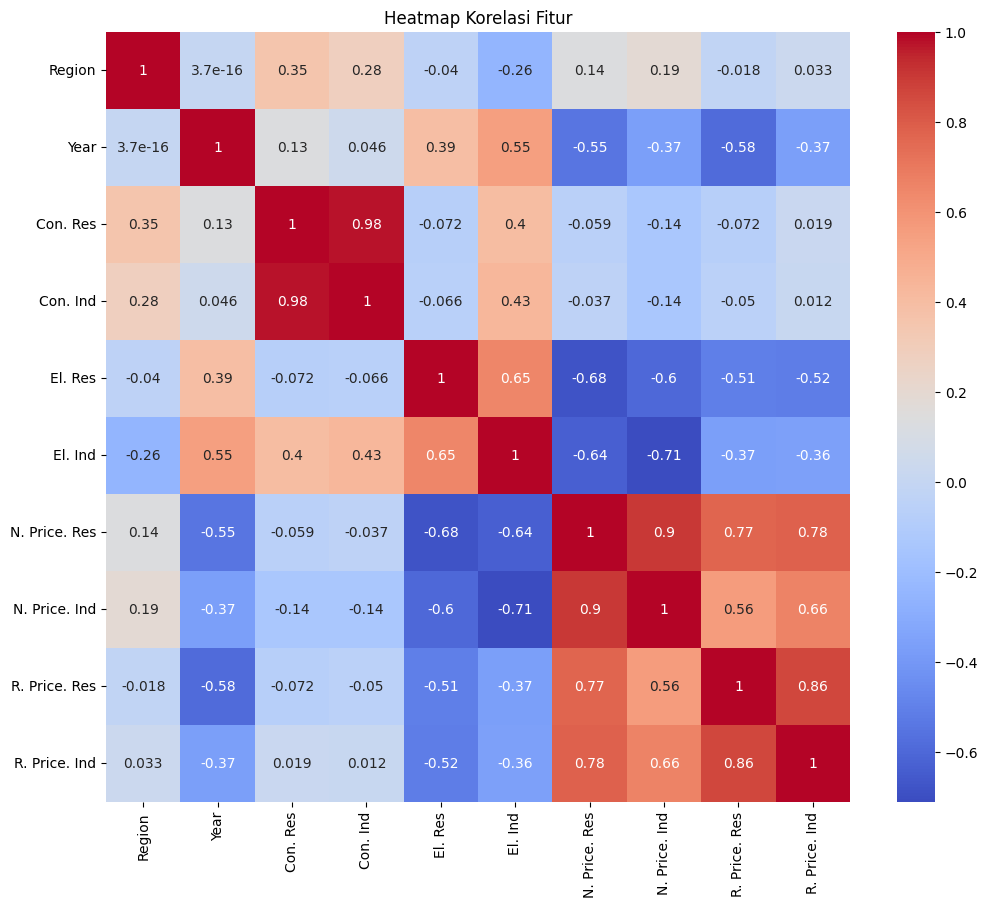

In [ ]:
# melihat korelasi antar fitur (heatmap)
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Heatmap Korelasi Fitur")
plt.show()

# Menentukan Label Data


In [ ]:
# Pisahkan dataset sesuai sektor
df_res = df[['Region', 'Year', 'Con. Res', 'El. Res', 'N. Price. Res', 'R. Price. Res']]

# Rename kolom
df_res.columns = ['Region', 'Year', 'Consumption', 'Intensity', 'NominalPrice', 'RealPrice']

# memisahkan fitur dan target
X_res = df_res.drop(columns=['Consumption'])
y_res = df_res['Consumption']

# Split train-test untuk RESIDENTIAL
X_res_train, X_res_test, y_res_train, y_res_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

print("Jumlah data train:", len(X_res_train))
print("Jumlah data test:", len(X_res_test))
print(X_res_train.head())
print(y_res_train.head())

Jumlah data train: 208
Jumlah data test: 52
     Region  Year    Intensity  NominalPrice   RealPrice
60        2  1996  4206.925193     25.094993  119.643117
247       7  2014  5311.174323     23.092475  110.537537
16        1  1991  4446.592720     26.095867  131.751258
55        4  1995  5418.462296     23.683123  119.055951
125       4  2002  5627.711787     21.828115  109.843418
60      9623354000
247     9238724000
16     11684494000
55     39919356000
125    45602930000
Name: Consumption, dtype: int64


In [ ]:
df_ind = df[['Region', 'Year', 'Con. Ind', 'El. Ind', 'N. Price. Ind', 'R. Price. Ind']]
df_ind.columns = ['Region', 'Year', 'Consumption', 'Intensity', 'NominalPrice', 'RealPrice']

# Split train-test untuk INDUSTRIAL
X_ind = df_ind.drop(columns=['Consumption'])
y_ind = df_ind['Consumption']

X_ind_train, X_ind_test, y_ind_train, y_ind_test = train_test_split(X_ind, y_ind, test_size=0.2, random_state=42)

print("Jumlah data train:", len(X_res_train))
print("Jumlah data test:", len(X_res_test))

Jumlah data train: 208
Jumlah data test: 52


In [ ]:
# Preprocessing
preprocess = ColumnTransformer([
    ("num", Pipeline([
        ("scale", StandardScaler()),
        ("poly", PolynomialFeatures(degree=2, include_bias=False))
    ]), ["Year", "Intensity", "NominalPrice", "RealPrice"]),
    ("cat", OneHotEncoder(drop='first', handle_unknown='ignore'), ["Region"])
])

# Membangun Model

## Linear Regression

In [ ]:
# --- Evaluasi ---
def eval_model(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{name}")
    print(f"R²: {r2:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")

In [ ]:

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# --- Model Residential ---
model_res = Pipeline([
    ("preprocess", preprocess),
    ("regressor", LinearRegression())
])
model_res.fit(X_res_train, y_res_train)

y_res_pred = model_res.predict(X_res_test)
eval_model(y_res_test, y_res_pred, "Residential")

feature_names_res = model_res.named_steps['preprocess'].get_feature_names_out()
coefficients_res = model_res.named_steps['regressor'].coef_
coef_res = pd.DataFrame({
    "Feature": feature_names_res,
    "Coefficient": coefficients_res
}).sort_values(by="Coefficient", ascending=False)
print("\nKoefisien Model Residential:")
print(coef_res)

# --- Model Industrial ---
model_ind = Pipeline([
    ("preprocess", preprocess),
    ("regressor", Ridge(alpha=1.0))
])
model_ind.fit(X_ind_train, y_ind_train)
y_ind_pred = model_ind.predict(X_ind_test)
eval_model(y_ind_test, y_ind_pred, "Industrial")

feature_names_ind = model_ind.named_steps['preprocess'].get_feature_names_out()
coefficients_ind = model_ind.named_steps['regressor'].coef_
coef_ind = pd.DataFrame({
    "Feature": feature_names_ind,
    "Coefficient": coefficients_ind
}).sort_values(by="Coefficient", ascending=False)
print("\nKoefisien Model Industrial:")
print(coef_ind)



Residential
R²: 0.9866
MSE: 7078954890869933056.0000
RMSE: 2660630543.8504
MAE: 1576775235.3548

Koefisien Model Residential:
                        Feature   Coefficient
22                cat__Region_9  5.242544e+10
17                cat__Region_4  1.209033e+10
0                     num__Year  5.242675e+09
13             num__RealPrice^2  3.170097e+09
7           num__Year RealPrice  2.358074e+09
10     num__Intensity RealPrice  1.358031e+09
11          num__NominalPrice^2  1.262684e+09
3                num__RealPrice  8.924941e+08
5           num__Year Intensity  3.222659e+08
2             num__NominalPrice -4.565743e+07
8              num__Intensity^2 -5.402417e+08
9   num__Intensity NominalPrice -9.487996e+08
1                num__Intensity -1.614347e+09
6        num__Year NominalPrice -2.052319e+09
12  num__NominalPrice RealPrice -2.480222e+09
4                   num__Year^2 -3.211836e+09
18                cat__Region_5 -9.250561e+09
21                cat__Region_8 -9.965111e+09

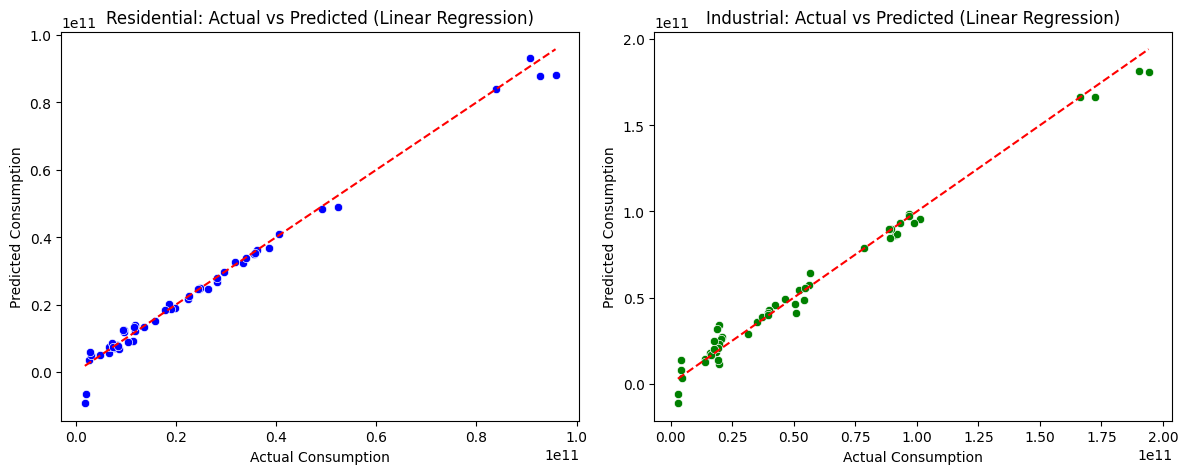

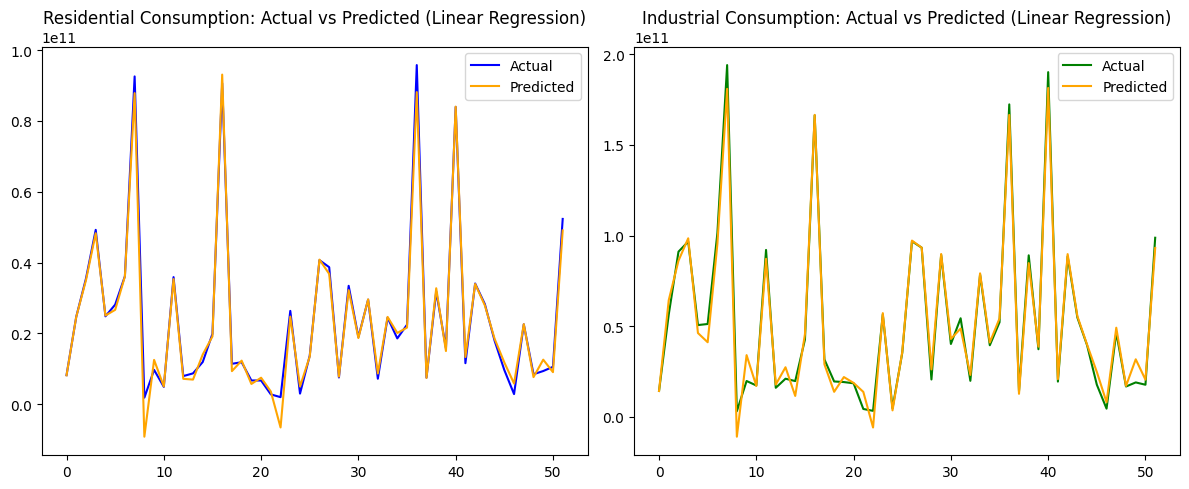

In [ ]:
# Buat DataFrame untuk perbandingan Linear Regression
res_compare_reg = pd.DataFrame({
    'Actual': y_res_test.values,
    'Predicted': y_res_pred
}).reset_index(drop=True)

ind_compare_reg = pd.DataFrame({
    'Actual': y_ind_test.values,
    'Predicted': y_ind_pred
}).reset_index(drop=True)

# Scatter Plot
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.scatterplot(x='Actual', y='Predicted', data=res_compare_reg, color='blue')
plt.plot([y_res_test.min(), y_res_test.max()], [y_res_test.min(), y_res_test.max()], 'r--')
plt.title("Residential: Actual vs Predicted (Linear Regression)")
plt.xlabel("Actual Consumption")
plt.ylabel("Predicted Consumption")

plt.subplot(1,2,2)
sns.scatterplot(x='Actual', y='Predicted', data=ind_compare_reg, color='green')
plt.plot([y_ind_test.min(), y_ind_test.max()], [y_ind_test.min(), y_ind_test.max()], 'r--')
plt.title("Industrial: Actual vs Predicted (Linear Regression)")
plt.xlabel("Actual Consumption")
plt.ylabel("Predicted Consumption")

plt.tight_layout()
plt.show()

# Line Plot
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(res_compare_reg['Actual'].values, label='Actual', color='blue')
plt.plot(res_compare_reg['Predicted'].values, label='Predicted', color='orange')
plt.title("Residential Consumption: Actual vs Predicted (Linear Regression)")
plt.legend()

plt.subplot(1,2,2)
plt.plot(ind_compare_reg['Actual'].values, label='Actual', color='green')
plt.plot(ind_compare_reg['Predicted'].values, label='Predicted', color='orange')
plt.title("Industrial Consumption: Actual vs Predicted (Linear Regression)")
plt.legend()

plt.tight_layout()
plt.show()


## Ridge Regression

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# --- Model Residential ---
ridge_model_res = Pipeline([
    ("preprocess", preprocess),
    ("regressor", Ridge(alpha=1.0))
])
ridge_model_res.fit(X_res_train, y_res_train)
ridge_y_res_pred = ridge_model_res.predict(X_res_test)
eval_model(y_res_test, ridge_y_res_pred, "Residential")

ridge_feature_names_res = ridge_model_res.named_steps['preprocess'].get_feature_names_out()
ridge_coefficients_res = ridge_model_res.named_steps['regressor'].coef_
ridge_coef_res = pd.DataFrame({
    "Feature": ridge_feature_names_res,
    "Coefficient": ridge_coefficients_res
}).sort_values(by="Coefficient", ascending=False)
print("\nKoefisien Model Residential:")
print(ridge_coef_res)

# --- Model Industrial ---
ridge_model_ind = Pipeline([
    ("preprocess", preprocess),
    ("regressor", Ridge(alpha=1.0))
])
ridge_model_ind.fit(X_ind_train, y_ind_train)
ridge_y_ind_pred = ridge_model_ind.predict(X_ind_test)
eval_model(y_ind_test, ridge_y_ind_pred, "Industrial")

ridge_feature_names_ind = ridge_model_ind.named_steps['preprocess'].get_feature_names_out()
ridge_coefficients_ind = ridge_model_ind.named_steps['regressor'].coef_
ridge_coef_ind = pd.DataFrame({
    "Feature": ridge_feature_names_ind,
    "Coefficient": ridge_coefficients_ind
}).sort_values(by="Coefficient", ascending=False)
print("\nKoefisien Model Industrial:")
print(ridge_coef_ind)



Residential
R²: 0.9839
MSE: 8465464627049644032.0000
RMSE: 2909547151.5426
MAE: 2040924439.8039

Koefisien Model Residential:
                        Feature   Coefficient
22                cat__Region_9  5.215852e+10
17                cat__Region_4  1.331887e+10
12  num__NominalPrice RealPrice  4.490774e+09
0                     num__Year  3.988336e+09
7           num__Year RealPrice  1.953384e+09
5           num__Year Intensity  9.427377e+08
3                num__RealPrice  4.653187e+08
6        num__Year NominalPrice -4.954170e+08
9   num__Intensity NominalPrice -7.992010e+08
10     num__Intensity RealPrice -9.651851e+08
2             num__NominalPrice -1.003892e+09
1                num__Intensity -1.276113e+09
13             num__RealPrice^2 -1.297302e+09
11          num__NominalPrice^2 -1.770570e+09
4                   num__Year^2 -1.967188e+09
8              num__Intensity^2 -2.447922e+09
18                cat__Region_5 -4.850374e+09
21                cat__Region_8 -7.609598e+09

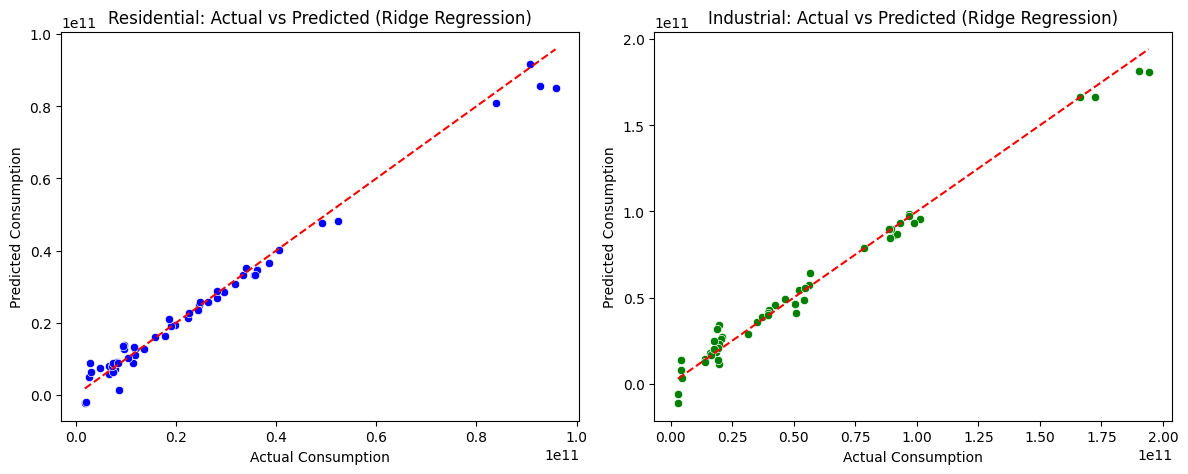

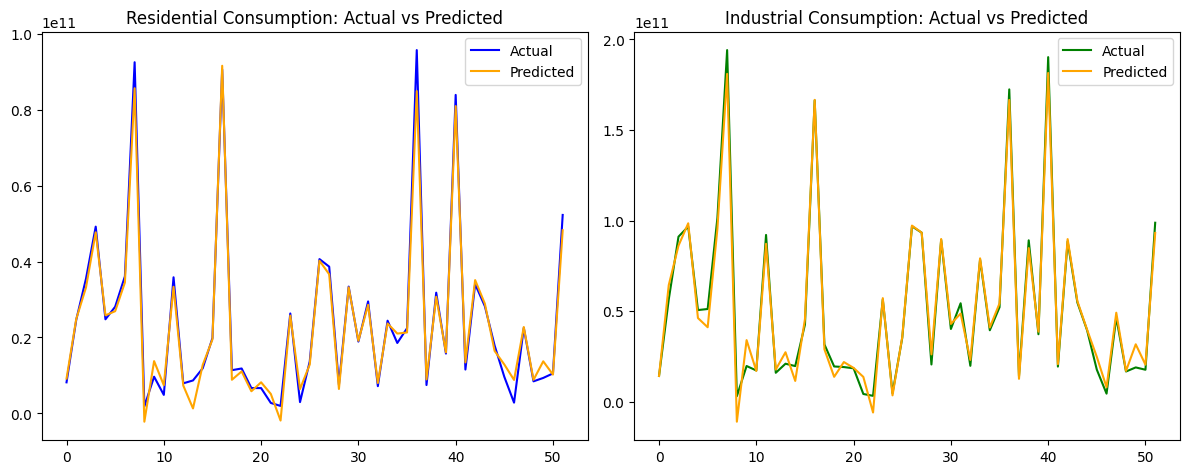

In [ ]:
# Buat DataFrame untuk perbandingan
res_compare_ridge = pd.DataFrame({
    'Actual': y_res_test.values,
    'Predicted': ridge_y_res_pred
}).reset_index(drop=True)

ind_compare_ridge = pd.DataFrame({
    'Actual': y_ind_test.values,
    'Predicted': ridge_y_ind_pred
}).reset_index(drop=True)

# === Scatter Plot (Prediksi vs Aktual) ===
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.scatterplot(x='Actual', y='Predicted', data=res_compare_ridge, color='blue')
plt.plot([y_res_test.min(), y_res_test.max()], [y_res_test.min(), y_res_test.max()], 'r--')
plt.title("Residential: Actual vs Predicted (Ridge Regression)")
plt.xlabel("Actual Consumption")
plt.ylabel("Predicted Consumption")

plt.subplot(1,2,2)
sns.scatterplot(x='Actual', y='Predicted', data=ind_compare_ridge, color='green')
plt.plot([y_ind_test.min(), y_ind_test.max()], [y_ind_test.min(), y_ind_test.max()], 'r--')
plt.title("Industrial: Actual vs Predicted (Ridge Regression)")
plt.xlabel("Actual Consumption")
plt.ylabel("Predicted Consumption")

plt.tight_layout()
plt.show()

# === Line Plot (Urutan Data) ===
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(res_compare_ridge['Actual'].values, label='Actual', color='blue')
plt.plot(res_compare_ridge['Predicted'].values, label='Predicted', color='orange')
plt.title("Residential Consumption: Actual vs Predicted")
plt.legend()

plt.subplot(1,2,2)
plt.plot(ind_compare_ridge['Actual'].values, label='Actual', color='green')
plt.plot(ind_compare_ridge['Predicted'].values, label='Predicted', color='orange')
plt.title("Industrial Consumption: Actual vs Predicted")
plt.legend()

plt.tight_layout()
plt.show()


## ElasticNet

In [ ]:
from sklearn.linear_model import ElasticNet

# --- Model Residential (ElasticNet) ---
enet_model_res = Pipeline([
    ("preprocess", preprocess),
    ("regressor", ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=5000, random_state=42))
])
enet_model_res.fit(X_res_train, y_res_train)
enet_y_res_pred = enet_model_res.predict(X_res_test)
eval_model(y_res_test, enet_y_res_pred, "Residential - ElasticNet")

enet_feature_names_res = enet_model_res.named_steps['preprocess'].get_feature_names_out()
enet_coefficients_res = enet_model_res.named_steps['regressor'].coef_
enet_coef_res = pd.DataFrame({
    "Feature": enet_feature_names_res,
    "Coefficient": enet_coefficients_res
}).sort_values(by="Coefficient", ascending=False)
print("\nKoefisien Model Residential - ElasticNet:")
print(enet_coef_res)

# --- Model Industrial (ElasticNet) ---
enet_model_ind = Pipeline([
    ("preprocess", preprocess),
    ("regressor", ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=5000, random_state=42))
])
enet_model_ind.fit(X_ind_train, y_ind_train)
enet_y_ind_pred = enet_model_ind.predict(X_ind_test)
eval_model(y_ind_test, enet_y_ind_pred, "Industrial - ElasticNet")

enet_feature_names_ind = enet_model_ind.named_steps['preprocess'].get_feature_names_out()
enet_coefficients_ind = enet_model_ind.named_steps['regressor'].coef_
enet_coef_ind = pd.DataFrame({
    "Feature": enet_feature_names_ind,
    "Coefficient": enet_coefficients_ind
}).sort_values(by="Coefficient", ascending=False)
print("\nKoefisien Model Industrial - ElasticNet:")
print(enet_coef_ind)



Residential - ElasticNet
R²: 0.8873
MSE: 59352245516407283712.0000
RMSE: 7704040856.3563
MAE: 5378996845.6102

Koefisien Model Residential - ElasticNet:
                        Feature   Coefficient
22                cat__Region_9  3.766492e+10
17                cat__Region_4  8.992435e+09
12  num__NominalPrice RealPrice  6.349785e+09
7           num__Year RealPrice  2.388107e+09
0                     num__Year  2.299581e+09
3                num__RealPrice  2.076117e+09
5           num__Year Intensity  2.072486e+09
6        num__Year NominalPrice  9.920538e+08
4                   num__Year^2 -6.609656e+08
1                num__Intensity -7.676298e+08
10     num__Intensity RealPrice -1.746758e+09
9   num__Intensity NominalPrice -1.890229e+09
16                cat__Region_3 -2.037831e+09
11          num__NominalPrice^2 -2.102420e+09
18                cat__Region_5 -2.260950e+09
2             num__NominalPrice -3.368076e+09
13             num__RealPrice^2 -3.447371e+09
21                

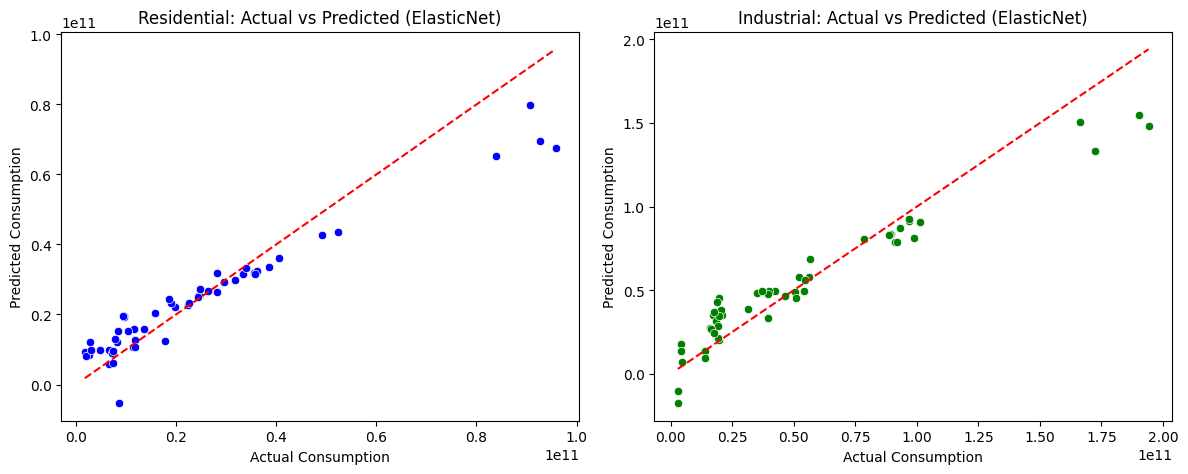

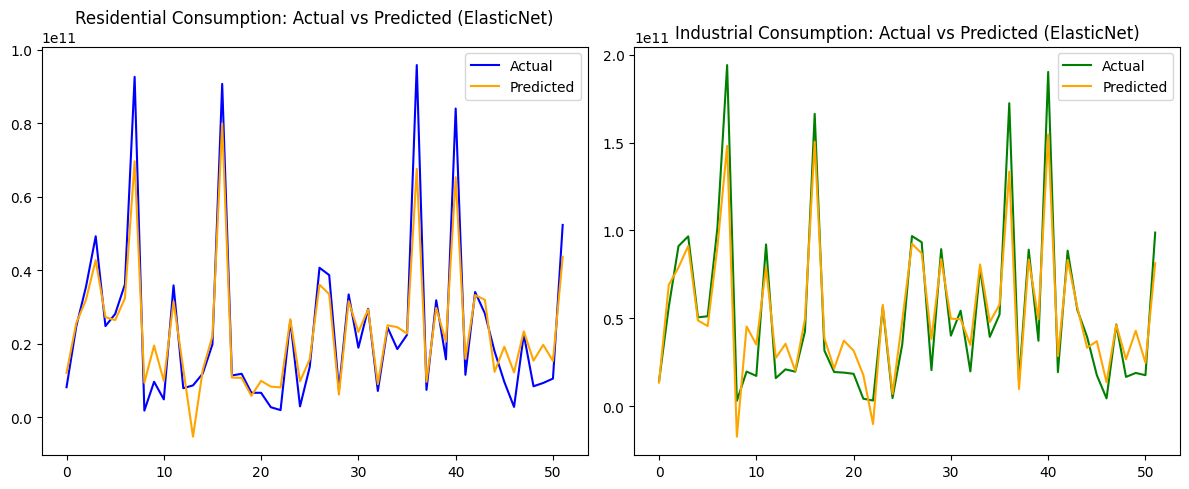

In [ ]:
# dataframe perbandingan aktual vs prediksi
res_compare_xgb = pd.DataFrame({
    'Actual': y_res_test.values,
    'Predicted': enet_y_res_pred
}).reset_index(drop=True)

ind_compare_xgb = pd.DataFrame({
    'Actual': y_ind_test.values,
    'Predicted': enet_y_ind_pred
}).reset_index(drop=True)

# Scatter Plot
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.scatterplot(x='Actual', y='Predicted', data=res_compare_xgb, color='blue')
plt.plot([y_res_test.min(), y_res_test.max()], [y_res_test.min(), y_res_test.max()], 'r--')
plt.title("Residential: Actual vs Predicted (ElasticNet)")
plt.xlabel("Actual Consumption")
plt.ylabel("Predicted Consumption")

plt.subplot(1,2,2)
sns.scatterplot(x='Actual', y='Predicted', data=ind_compare_xgb, color='green')
plt.plot([y_ind_test.min(), y_ind_test.max()], [y_ind_test.min(), y_ind_test.max()], 'r--')
plt.title("Industrial: Actual vs Predicted (ElasticNet)")
plt.xlabel("Actual Consumption")
plt.ylabel("Predicted Consumption")

plt.tight_layout()
plt.show()

# Line Plot
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(res_compare_xgb['Actual'].values, label='Actual', color='blue')
plt.plot(res_compare_xgb['Predicted'].values, label='Predicted', color='orange')
plt.title("Residential Consumption: Actual vs Predicted (ElasticNet)")
plt.legend()

plt.subplot(1,2,2)
plt.plot(ind_compare_xgb['Actual'].values, label='Actual', color='green')
plt.plot(ind_compare_xgb['Predicted'].values, label='Predicted', color='orange')
plt.title("Industrial Consumption: Actual vs Predicted (ElasticNet)")
plt.legend()

plt.tight_layout()
plt.show()


# Mengevaluasi Model

In [ ]:
# --- Hitung Prediksi (Jika belum ada, sesuaikan dengan model yang telah dilatih) ---
# Linear
model_res = Pipeline([
    ("preprocess", preprocess),
    ("regressor", LinearRegression())
])
model_res.fit(X_res_train, y_res_train)
y_res_lin_pred = model_res.predict(X_res_test)

ridge_model_res = Pipeline([
    ("preprocess", preprocess),
    ("regressor", Ridge(alpha=1.0))
])
ridge_model_res.fit(X_res_train, y_res_train)
y_res_ridge_pred = ridge_model_res.predict(X_res_test)

enet_model_res = Pipeline([
    ("preprocess", preprocess),
    ("regressor", ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=5000, random_state=42))
])
enet_model_res.fit(X_res_train, y_res_train)
y_res_enet_pred = enet_model_res.predict(X_res_test)




# Ridge
model_ind = Pipeline([
    ("preprocess", preprocess),
    ("regressor", LinearRegression())
])
model_ind.fit(X_ind_train, y_ind_train)
y_ind_lin_pred = model_ind.predict(X_ind_test)

ridge_model_ind = Pipeline([
    ("preprocess", preprocess),
    ("regressor", Ridge(alpha=1.0))
])
ridge_model_ind.fit(X_ind_train, y_ind_train)
y_ind_ridge_pred = ridge_model_ind.predict(X_ind_test)

enet_model_ind = Pipeline([
    ("preprocess", preprocess),
    ("regressor", ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=5000, random_state=42))
])
enet_model_ind.fit(X_ind_train, y_ind_train)
y_ind_enet_pred = enet_model_ind.predict(X_ind_test)


# ElasticNet

# --- Buat Tabel Perbandingan ---
comparison = pd.DataFrame({
    "Model": [
        "Linear Regression (Res)", "Ridge Regression (Res)", "ElasticNet (Res)",
        "Linear Regression (Ind)", "Ridge Regression (Ind)", "ElasticNet (Ind)",
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_res_test, y_res_lin_pred)),
        np.sqrt(mean_squared_error(y_res_test, y_res_ridge_pred)),
        np.sqrt(mean_squared_error(y_res_test, y_res_enet_pred)),
        np.sqrt(mean_squared_error(y_ind_test, y_ind_lin_pred)),
        np.sqrt(mean_squared_error(y_ind_test, y_ind_ridge_pred)),
        np.sqrt(mean_squared_error(y_ind_test, y_ind_enet_pred)),
    ],
    "R²": [
        r2_score(y_res_test, y_res_lin_pred),
        r2_score(y_res_test, y_res_ridge_pred),
        r2_score(y_res_test, y_res_enet_pred),
        r2_score(y_ind_test, y_ind_lin_pred),
        r2_score(y_ind_test, y_ind_ridge_pred),
        r2_score(y_ind_test, y_ind_enet_pred),
    ]
})

print(comparison)


                     Model          RMSE        R²
0  Linear Regression (Res)  2.660631e+09  0.986563
1   Ridge Regression (Res)  2.909547e+09  0.983931
2         ElasticNet (Res)  7.704041e+09  0.887341
3  Linear Regression (Ind)  3.306944e+09  0.995175
4   Ridge Regression (Ind)  5.696952e+09  0.985681
5         ElasticNet (Ind)  1.480375e+10  0.903312


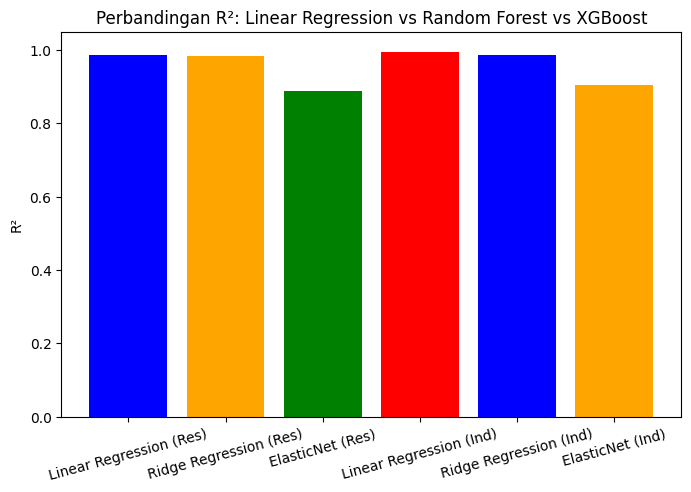

In [ ]:
plt.figure(figsize=(8,5))
plt.bar(comparison["Model"], comparison["R²"], color=["blue","orange","green","red"])
plt.title("Perbandingan R²: Linear Regression vs Random Forest vs XGBoost")
plt.ylabel("R²")
plt.ylim(0,1.05)
plt.xticks(rotation=15)
plt.show()


# Mengoptimasi Model

## Linear Regression

### Residential

In [ ]:
# Pipeline Residential
pipe_res = Pipeline([
    ("preprocess", preprocess),
    ("regressor", LinearRegression())
])

# Grid: hanya 1 hyperparameter yang bisa dioptimasi
param_grid = {
    "regressor__fit_intercept": [True, False],
}

# GridSearchCV untuk Residential
grid_res_linear = GridSearchCV(pipe_res, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_res_linear.fit(X_res_train, y_res_train)

best_model_res = grid_res_linear.best_estimator_
y_res_pred = best_model_res.predict(X_res_test)

print("Best Linear Regression Params (Residential):", grid_res_linear.best_params_)
eval_model(y_res_test, y_res_pred, "Residential")

# Koefisien
feature_names_res = best_model_res.named_steps['preprocess'].get_feature_names_out()
coefficients_res = best_model_res.named_steps['regressor'].coef_
coef_res = pd.DataFrame({
    "Feature": feature_names_res,
    "Coefficient": coefficients_res
}).sort_values(by="Coefficient", ascending=False)

print("\nKoefisien Model Residential:")
print(coef_res)

Best Linear Regression Params (Residential): {'regressor__fit_intercept': True}

Residential
R²: 0.9866
MSE: 7078954890869933056.0000
RMSE: 2660630543.8504
MAE: 1576775235.3548

Koefisien Model Residential:
                        Feature   Coefficient
22                cat__Region_9  5.242544e+10
17                cat__Region_4  1.209033e+10
0                     num__Year  5.242675e+09
13             num__RealPrice^2  3.170097e+09
7           num__Year RealPrice  2.358074e+09
10     num__Intensity RealPrice  1.358031e+09
11          num__NominalPrice^2  1.262684e+09
3                num__RealPrice  8.924941e+08
5           num__Year Intensity  3.222659e+08
2             num__NominalPrice -4.565743e+07
8              num__Intensity^2 -5.402417e+08
9   num__Intensity NominalPrice -9.487996e+08
1                num__Intensity -1.614347e+09
6        num__Year NominalPrice -2.052319e+09
12  num__NominalPrice RealPrice -2.480222e+09
4                   num__Year^2 -3.211836e+09
18         

### Industrial

In [ ]:
# Pipeline Industrial
pipe_ind = Pipeline([
    ("preprocess", preprocess),
    ("regressor", LinearRegression())
])

# Grid: hanya 1 hyperparameter yang bisa dioptimasi
param_grid = {
    "regressor__fit_intercept": [True, False],
}

# GridSearchCV untuk Industrial
grid_ind_linear = GridSearchCV(pipe_ind, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_ind_linear.fit(X_ind_train, y_ind_train)

best_model_ind = grid_ind_linear.best_estimator_
y_ind_pred = best_model_ind.predict(X_ind_test)

print("Best Linear Regression Params (Industrial):", grid_ind_linear.best_params_)
eval_model(y_ind_test, y_ind_pred, "Industrial")

# Koefisien
feature_names_ind = best_model_ind.named_steps['preprocess'].get_feature_names_out()
coefficients_ind = best_model_ind.named_steps['regressor'].coef_
coef_ind = pd.DataFrame({
    "Feature": feature_names_ind,
    "Coefficient": coefficients_ind
}).sort_values(by="Coefficient", ascending=False)

print("\nKoefisien Model Industrial:")
print(coef_ind)

Best Linear Regression Params (Industrial): {'regressor__fit_intercept': True}

Industrial
R²: 0.9952
MSE: 10935880066027911168.0000
RMSE: 3306944218.7657
MAE: 2545268668.5852

Koefisien Model Industrial:
                        Feature   Coefficient
22                cat__Region_9  9.412186e+10
1                num__Intensity  1.032914e+10
17                cat__Region_4  7.873221e+09
5           num__Year Intensity  3.431549e+09
6        num__Year NominalPrice  3.359261e+09
10     num__Intensity RealPrice  2.761629e+09
13             num__RealPrice^2  4.824182e+08
3                num__RealPrice  4.493763e+08
2             num__NominalPrice  3.512783e+07
12  num__NominalPrice RealPrice -1.607494e+07
11          num__NominalPrice^2 -1.734839e+09
7           num__Year RealPrice -2.020513e+09
4                   num__Year^2 -2.362173e+09
8              num__Intensity^2 -2.695846e+09
0                     num__Year -2.860837e+09
9   num__Intensity NominalPrice -5.391764e+09
18           

## Ridge Regression

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# === Grid Search for Ridge - Residential ===
param_grid = {
    "regressor__alpha": [0.01, 0.1, 1.0, 10.0, 100.0],
    "regressor__fit_intercept": [True, False]
}

ridge_pipeline_res = Pipeline([
    ("preprocess", preprocess),
    ("regressor", Ridge())
])

grid_res_ridge = GridSearchCV(ridge_pipeline_res, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_res_ridge.fit(X_res_train, y_res_train)

best_ridge_res = grid_res_ridge.best_estimator_

# save model
joblib.dump(best_ridge_res, "pipeline_res.pkl")

y_res_pred = best_ridge_res.predict(X_res_test)

print("Best Ridge Params (Residential):", grid_res_ridge.best_params_)
eval_model(y_res_test, y_res_pred, "Residential")

# Koefisien Residential
feature_names_res = best_ridge_res.named_steps['preprocess'].get_feature_names_out()
coefficients_res = best_ridge_res.named_steps['regressor'].coef_
coef_res = pd.DataFrame({
    "Feature": feature_names_res,
    "Coefficient": coefficients_res
}).sort_values(by="Coefficient", ascending=False)
print("\nKoefisien Ridge Model Residential:")
print(coef_res)

# === Grid Search for Ridge - Industrial ===
ridge_pipeline_ind = Pipeline([
    ("preprocess", preprocess),
    ("regressor", Ridge())
])

grid_ind_ridge = GridSearchCV(ridge_pipeline_ind, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_ind_ridge.fit(X_ind_train, y_ind_train)

best_ridge_ind = grid_ind_ridge.best_estimator_
y_ind_pred = best_ridge_ind.predict(X_ind_test)

print("Best Ridge Params (Industrial):", grid_ind_ridge.best_params_)
eval_model(y_ind_test, y_ind_pred, "Industrial")

# Koefisien Industrial
feature_names_ind = best_ridge_ind.named_steps['preprocess'].get_feature_names_out()
coefficients_ind = best_ridge_ind.named_steps['regressor'].coef_
coef_ind = pd.DataFrame({
    "Feature": feature_names_ind,
    "Coefficient": coefficients_ind
}).sort_values(by="Coefficient", ascending=False)
print("\nKoefisien Ridge Model Industrial:")
print(coef_ind)


Best Ridge Params (Residential): {'regressor__alpha': 0.01, 'regressor__fit_intercept': True}

Residential
R²: 0.9866
MSE: 7036626603425140736.0000
RMSE: 2652664057.7776
MAE: 1575346336.4121

Koefisien Ridge Model Residential:
                        Feature   Coefficient
22                cat__Region_9  5.245230e+10
17                cat__Region_4  1.216918e+10
0                     num__Year  5.216346e+09
13             num__RealPrice^2  3.066693e+09
7           num__Year RealPrice  2.345781e+09
10     num__Intensity RealPrice  1.297317e+09
11          num__NominalPrice^2  1.189759e+09
3                num__RealPrice  8.249749e+08
5           num__Year Intensity  3.352328e+08
2             num__NominalPrice -2.271400e+07
8              num__Intensity^2 -5.749006e+08
9   num__Intensity NominalPrice -9.308369e+08
1                num__Intensity -1.624027e+09
6        num__Year NominalPrice -2.017624e+09
12  num__NominalPrice RealPrice -2.311125e+09
4                   num__Year^2 -3.18

## ElasticNet

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Grid Search untuk ElasticNet - Residential ---
param_grid_enet = {
    "regressor__alpha": [0.001, 0.01, 0.1, 1.0, 10.0],
    "regressor__l1_ratio": [0.1, 0.5, 0.7, 0.9, 1.0],
}

elasticnet_pipeline_res = Pipeline([
    ("preprocess", preprocess),
    ("regressor", ElasticNet(max_iter=5000, random_state=42))
])

grid_res_enet = GridSearchCV(elasticnet_pipeline_res, param_grid_enet, cv=5, scoring="r2", n_jobs=-1)
grid_res_enet.fit(X_res_train, y_res_train)

best_enet_res = grid_res_enet.best_estimator_
y_res_pred_enet = best_enet_res.predict(X_res_test)

print("Best ElasticNet Params (Residential):", grid_res_enet.best_params_)
eval_model(y_res_test, y_res_pred_enet, "Residential - ElasticNet (Optimized)")

# Koefisien Residential ElasticNet
feature_names_res = best_enet_res.named_steps['preprocess'].get_feature_names_out()
coefficients_res = best_enet_res.named_steps['regressor'].coef_
coef_res = pd.DataFrame({
    "Feature": feature_names_res,
    "Coefficient": coefficients_res
}).sort_values(by="Coefficient", ascending=False)
print("\nKoefisien Model Residential - ElasticNet (Optimized):")
print(coef_res)


# --- Grid Search untuk ElasticNet - Industrial ---
elasticnet_pipeline_ind = Pipeline([
    ("preprocess", preprocess),
    ("regressor", ElasticNet(max_iter=5000, random_state=42))
])

grid_ind_enet = GridSearchCV(elasticnet_pipeline_ind, param_grid_enet, cv=5, scoring="r2", n_jobs=-1)
grid_ind_enet.fit(X_ind_train, y_ind_train)
best_enet_ind = grid_ind_enet.best_estimator_
# save model
joblib.dump(best_enet_ind, "pipeline_ind.pkl")
y_ind_pred_enet = best_enet_ind.predict(X_ind_test)

print("Best ElasticNet Params (Industrial):", grid_ind_enet.best_params_)
eval_model(y_ind_test, y_ind_pred_enet, "Industrial - ElasticNet (Optimized)")

# Koefisien Industrial ElasticNet
feature_names_ind = best_enet_ind.named_steps['preprocess'].get_feature_names_out()
coefficients_ind = best_enet_ind.named_steps['regressor'].coef_
coef_ind = pd.DataFrame({
    "Feature": feature_names_ind,
    "Coefficient": coefficients_ind
}).sort_values(by="Coefficient", ascending=False)
print("\nKoefisien Model Industrial - ElasticNet (Optimized):")
print(coef_ind)


Best ElasticNet Params (Residential): {'regressor__alpha': 10.0, 'regressor__l1_ratio': 1.0}

Residential - ElasticNet (Optimized)
R²: 0.9866
MSE: 7078954674031694848.0000
RMSE: 2660630503.1010
MAE: 1576775173.7744

Koefisien Model Residential - ElasticNet (Optimized):
                        Feature   Coefficient
22                cat__Region_9  5.242544e+10
17                cat__Region_4  1.209034e+10
0                     num__Year  5.242674e+09
13             num__RealPrice^2  3.170095e+09
7           num__Year RealPrice  2.358074e+09
10     num__Intensity RealPrice  1.358030e+09
11          num__NominalPrice^2  1.262683e+09
3                num__RealPrice  8.924912e+08
5           num__Year Intensity  3.222659e+08
2             num__NominalPrice -4.565549e+07
8              num__Intensity^2 -5.402419e+08
9   num__Intensity NominalPrice -9.487989e+08
1                num__Intensity -1.614346e+09
6        num__Year NominalPrice -2.052318e+09
12  num__NominalPrice RealPrice -2.48021

In [ ]:
# Ambil model terbaik
best_ridge_res = grid_res_ridge.best_estimator_
best_ridge_ind = grid_ind_ridge.best_estimator_
best_linear_res = grid_res_linear.best_estimator_
best_linear_ind = grid_ind_linear.best_estimator_
best_enet_res = grid_res_enet.best_estimator_
best_enet_ind = grid_ind_enet.best_estimator_

# Prediksi
best_ridge_res_pred = best_ridge_res.predict(X_res_test)
best_ridge_ind_pred = best_ridge_ind.predict(X_ind_test)
best_linear_res_pred = best_linear_res.predict(X_res_test)
best_linear_ind_pred = best_linear_ind.predict(X_ind_test)
best_enet_res_pred = best_enet_res.predict(X_res_test)
best_enet_ind_pred = best_enet_ind.predict(X_ind_test)

# Evaluasi
print("=== Optimized Linear ===")
eval_model(y_res_test, best_ridge_res_pred, "Residential Linear Optimized")
eval_model(y_ind_test, best_ridge_ind_pred, "Industrial Linear Optimized")

print("\n=== Optimized Ridge ===")
eval_model(y_res_test, best_linear_res_pred, "Residential Ridge Optimized")
eval_model(y_ind_test, best_linear_ind_pred, "Industrial Ridge Optimized")

print("\n=== Optimized ElesticNet ===")
eval_model(y_res_test, best_enet_res_pred, "Residential enet Optimized")
eval_model(y_ind_test, best_enet_ind_pred, "Industrial enet Optimized")

=== Optimized Linear ===

Residential Linear Optimized
R²: 0.9866
MSE: 7036626603425140736.0000
RMSE: 2652664057.7776
MAE: 1575346336.4121

Industrial Linear Optimized
R²: 0.9951
MSE: 11052025477267148800.0000
RMSE: 3324458674.3209
MAE: 2564327527.6506

=== Optimized Ridge ===

Residential Ridge Optimized
R²: 0.9866
MSE: 7078954890869933056.0000
RMSE: 2660630543.8504
MAE: 1576775235.3548

Industrial Ridge Optimized
R²: 0.9952
MSE: 10935880066027911168.0000
RMSE: 3306944218.7657
MAE: 2545268668.5852

=== Optimized ElesticNet ===

Residential enet Optimized
R²: 0.9866
MSE: 7078954674031694848.0000
RMSE: 2660630503.1010
MAE: 1576775173.7744

Industrial enet Optimized
R²: 0.9952
MSE: 10935879574239670272.0000
RMSE: 3306944144.4088
MAE: 2545268594.4542


In [ ]:
# Buat DataFrame perbandingan lengkap (default + optimized)
comparison_all = pd.DataFrame({
    "Model": [
        # Default
        "Linear (Default) - Res",
        "Ridge (Default) - Res",
        "ElasticNet (Default) - Res",
        "Linear (Default) - Ind",
        "Ridge (Default) - Ind",
        "ElasticNet (Default) - Ind",

        # Optimized
        "Linear (Optimized) - Res",
        "Ridge (Optimized) - Res",
        "ElasticNet (Optimized) - Res",
        "Linear (Optimized) - Ind",
        "Ridge (Optimized) - Ind",
        "ElasticNet (Optimized) - Ind",
    ],
    "RMSE": [
        # Default
        np.sqrt(mean_squared_error(y_res_test, y_res_pred)),
        np.sqrt(mean_squared_error(y_res_test, ridge_y_res_pred)),
        np.sqrt(mean_squared_error(y_res_test, enet_y_res_pred)),
        np.sqrt(mean_squared_error(y_ind_test, y_ind_pred)),
        np.sqrt(mean_squared_error(y_ind_test, ridge_y_ind_pred)),
        np.sqrt(mean_squared_error(y_ind_test, enet_y_ind_pred)),

        # Optimized
        np.sqrt(mean_squared_error(y_res_test, best_linear_res_pred)),
        np.sqrt(mean_squared_error(y_res_test, best_ridge_res_pred)),
        np.sqrt(mean_squared_error(y_res_test, best_enet_res_pred)),
        np.sqrt(mean_squared_error(y_ind_test, best_linear_ind_pred)),
        np.sqrt(mean_squared_error(y_ind_test, best_ridge_ind_pred)),
        np.sqrt(mean_squared_error(y_ind_test, best_enet_ind_pred)),
    ],
    "R²": [
        # Default
        r2_score(y_res_test, y_res_pred),
        r2_score(y_res_test, ridge_y_res_pred),
        r2_score(y_res_test, enet_y_res_pred),
        r2_score(y_ind_test, y_ind_pred),
        r2_score(y_ind_test, ridge_y_ind_pred),
        r2_score(y_ind_test, enet_y_ind_pred),

        # Optimized
        r2_score(y_res_test, best_linear_res_pred),
        r2_score(y_res_test, best_ridge_res_pred),
        r2_score(y_res_test, best_enet_res_pred),
        r2_score(y_ind_test, best_linear_ind_pred),
        r2_score(y_ind_test, best_ridge_ind_pred),
        r2_score(y_ind_test, best_enet_ind_pred),
    ]
})

# Urutkan berdasarkan RMSE (semakin kecil semakin baik)
comparison_all = comparison_all.sort_values(by="RMSE", ascending=True).reset_index(drop=True)
comparison_all


,Model,RMSE,R²
0,Linear (Default) - Res,2.652664e+09,0.986643
1,Ridge (Optimized) - Res,2.652664e+09,0.986643
2,ElasticNet (Optimized) - Res,2.660631e+09,0.986563
3,Linear (Optimized) - Res,2.660631e+09,0.986563
4,Ridge (Default) - Res,2.909547e+09,0.983931
5,ElasticNet (Optimized) - Ind,3.306944e+09,0.995175
6,Linear (Optimized) - Ind,3.306944e+09,0.995175
7,Linear (Default) - Ind,3.324459e+09,0.995124
8,Ridge (Optimized) - Ind,3.324459e+09,0.995124
9,Ridge (Default) - Ind,5.696952e+09,0.985681


In [ ]:
model_mapping = {
    # Residential (Res)
    "Linear (Default) - Res": model_res,
    "Ridge (Default) - Res": ridge_model_res,
    "ElasticNet (Default) - Res": enet_model_res,
    "Linear (Optimized) - Res": best_model_res,
    "Ridge (Optimized) - Res": best_ridge_res,
    "ElasticNet (Optimized) - Res": best_enet_res,

    # Industrial (Ind)
    "Linear (Default) - Ind": model_ind,
    "Ridge (Default) - Ind": ridge_model_ind,
    "ElasticNet (Default) - Ind": enet_model_ind,
    "Linear (Optimized) - Ind": best_linear_ind,
    "Ridge (Optimized) - Ind": best_ridge_ind,
    "ElasticNet (Optimized) - Ind": best_enet_ind
}


In [ ]:
# feature_cols = ["Region",  "Year", "Intensity", "NominalPrice", "RealPrice"]

# pipeline_res = Pipeline([
#     ("preprocess", preprocess),
#     ("regressor", model_res)
# ])

# pipeline_ind = Pipeline([
#     ("preprocess", preprocess),
#     ("regressor", best_enet_ind)
# ])

# # Simpan pipeline langsung ke file .pkl
# joblib.dump(pipeline_res, "pipeline_res.pkl")
# joblib.dump(pipeline_ind, "pipeline_ind.pkl")

# print("Pipeline Residential disimpan sebagai: pipeline_res.pkl")
# print("Pipeline Industrial disimpan sebagai: pipeline_ind.pkl")


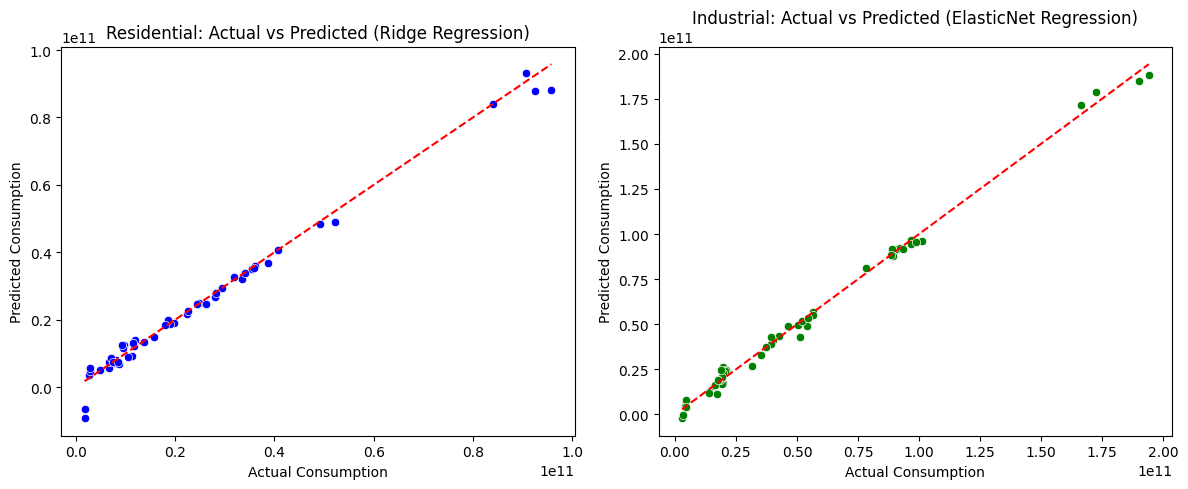

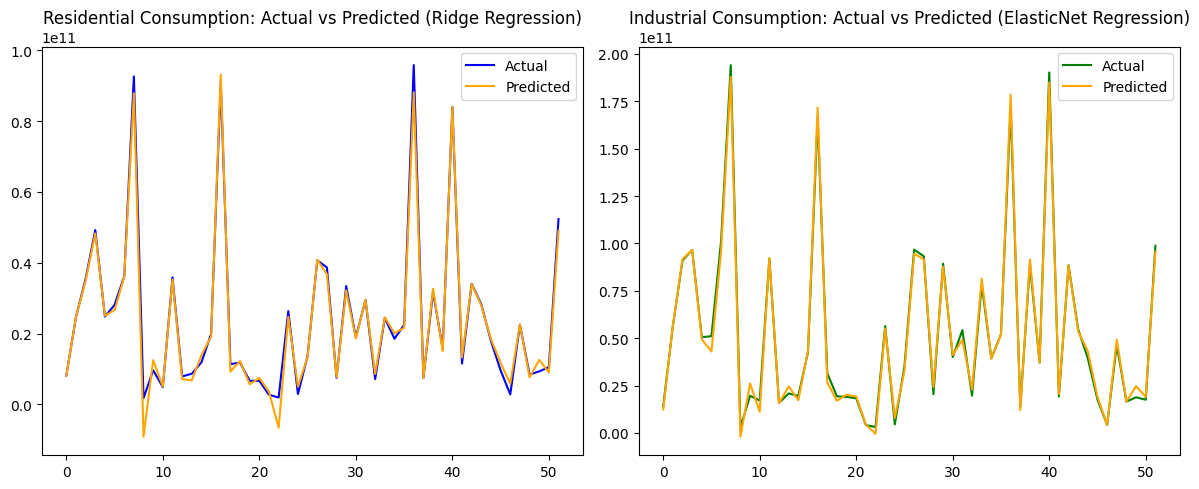

In [ ]:
# dataframe perbandingan aktual vs prediksi
best_res_compare_xgb = pd.DataFrame({
    'Actual': y_res_test.values,
    'Predicted': best_ridge_res_pred
}).reset_index(drop=True)

best_ind_compare_xgb = pd.DataFrame({
    'Actual': y_ind_test.values,
    'Predicted': best_enet_ind_pred
}).reset_index(drop=True)

# Scatter Plot
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.scatterplot(x='Actual', y='Predicted', data=best_res_compare_xgb, color='blue')
plt.plot([y_res_test.min(), y_res_test.max()], [y_res_test.min(), y_res_test.max()], 'r--')
plt.title("Residential: Actual vs Predicted (Ridge Regression)")
plt.xlabel("Actual Consumption")
plt.ylabel("Predicted Consumption")

plt.subplot(1,2,2)
sns.scatterplot(x='Actual', y='Predicted', data=best_ind_compare_xgb, color='green')
plt.plot([y_ind_test.min(), y_ind_test.max()], [y_ind_test.min(), y_ind_test.max()], 'r--')
plt.title("Industrial: Actual vs Predicted (ElasticNet Regression)")
plt.xlabel("Actual Consumption")
plt.ylabel("Predicted Consumption")

plt.tight_layout()
plt.show()

# Line Plot
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(best_res_compare_xgb['Actual'].values, label='Actual', color='blue')
plt.plot(best_res_compare_xgb['Predicted'].values, label='Predicted', color='orange')
plt.title("Residential Consumption: Actual vs Predicted (Ridge Regression)")
plt.legend()

plt.subplot(1,2,2)
plt.plot(best_ind_compare_xgb['Actual'].values, label='Actual', color='green')
plt.plot(best_ind_compare_xgb['Predicted'].values, label='Predicted', color='orange')
plt.title("Industrial Consumption: Actual vs Predicted (ElasticNet Regression)")
plt.legend()

plt.tight_layout()
plt.show()


/tmp/ipython-input-91555114.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="RMSE", data=comparison_all, palette="viridis")


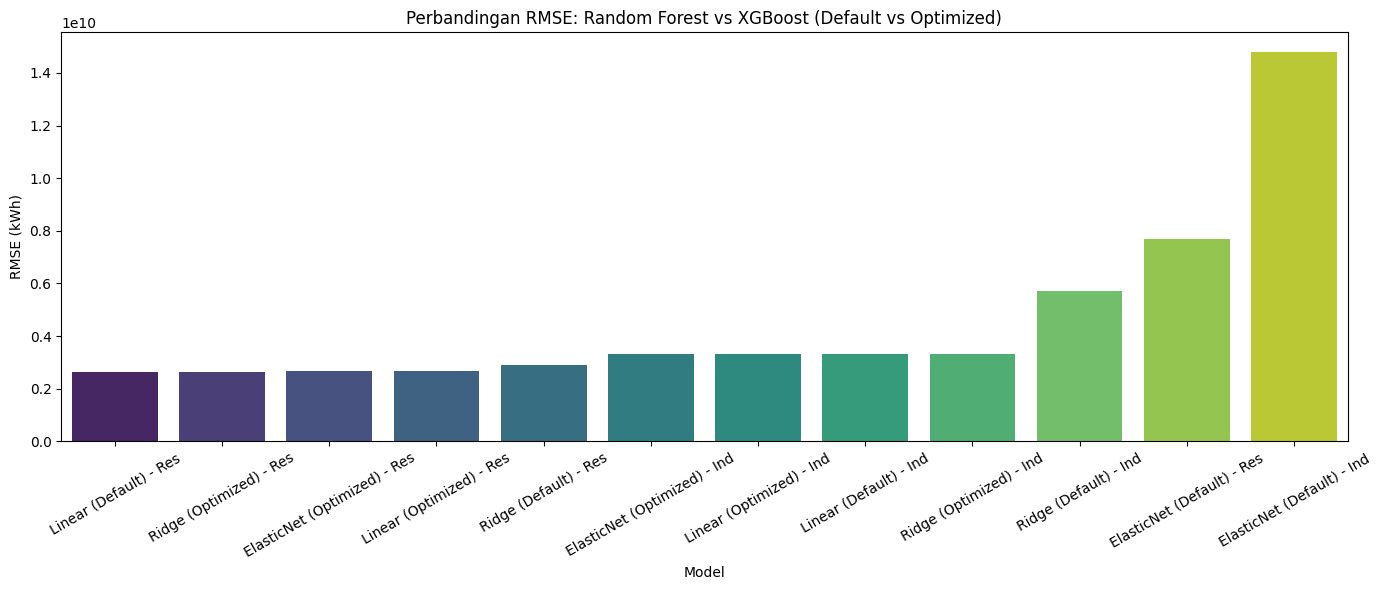

/tmp/ipython-input-91555114.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="R²", data=comparison_all, palette="magma")


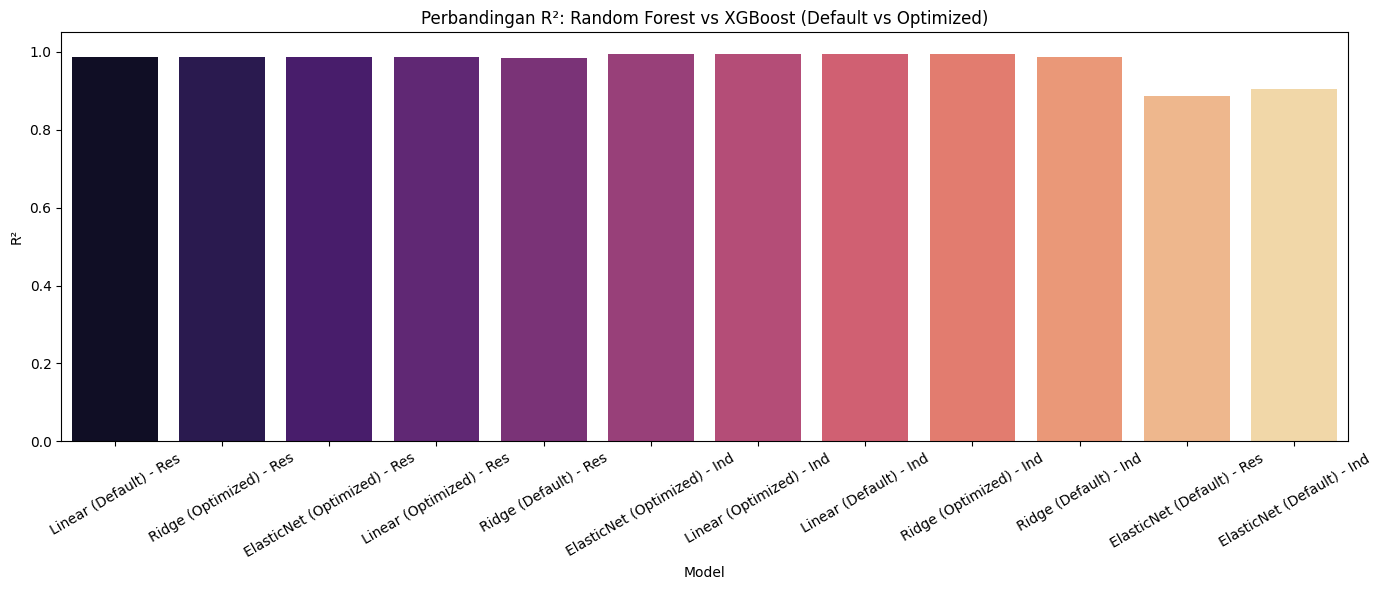

In [ ]:
plt.figure(figsize=(14,6))
sns.barplot(x="Model", y="RMSE", data=comparison_all, palette="viridis")
plt.title("Perbandingan RMSE: Random Forest vs XGBoost (Default vs Optimized)")
plt.ylabel("RMSE (kWh)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14,6))
sns.barplot(x="Model", y="R²", data=comparison_all, palette="magma")
plt.title("Perbandingan R²: Random Forest vs XGBoost (Default vs Optimized)")
plt.ylabel("R²")
plt.ylim(0,1.05)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


# Interpretasi Model

## Shap (SHapley Additive exPlanations)

In [ ]:
pipeline_res = Pipeline([
    ("preprocess", preprocess),
    ("regressor", LinearRegression())
])

model_res = pipeline_res.named_steps['regressor']
X_res_train_transformed = pipeline_res.named_steps['preprocess'].transform(X_res_train)
X_res_test_transformed = pipeline_res.named_steps['preprocess'].transform(X_res_test)
pipeline_res.fit(X_res_train, y_res_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['Year', 'Intensity',
                                                   'NominalPrice',
                                                   'RealPrice']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Region'])])),
                ('regressor', LinearRegression())])

In [ ]:
import shap

# Buat explainer untuk model linear
explainer_res = shap.Explainer(model_res.predict, X_res_train_transformed)

# Dapatkan nilai SHAP
shap_values_res = explainer_res(X_res_test_transformed)


In [ ]:
# (Optional) Set nama fitur jika hilang
try:
    shap_values_res.feature_names = pipeline_res.named_steps['preprocess'].get_feature_names_out()
except:
    pass


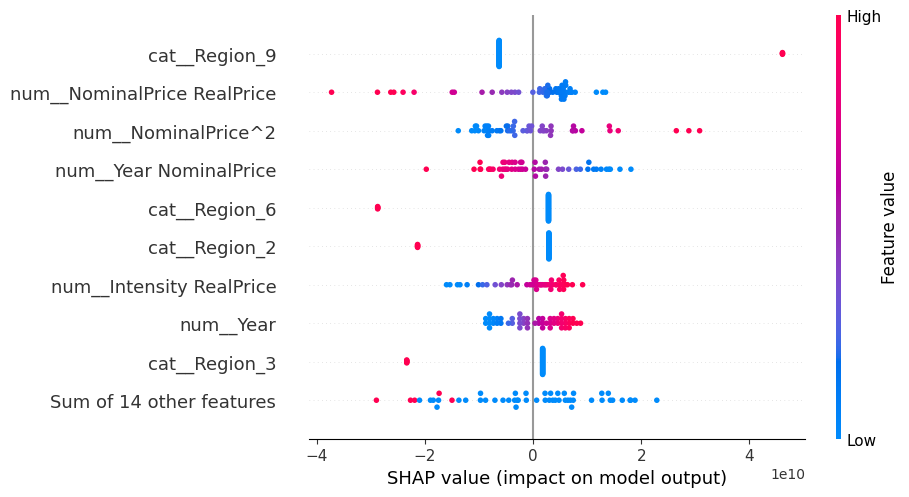

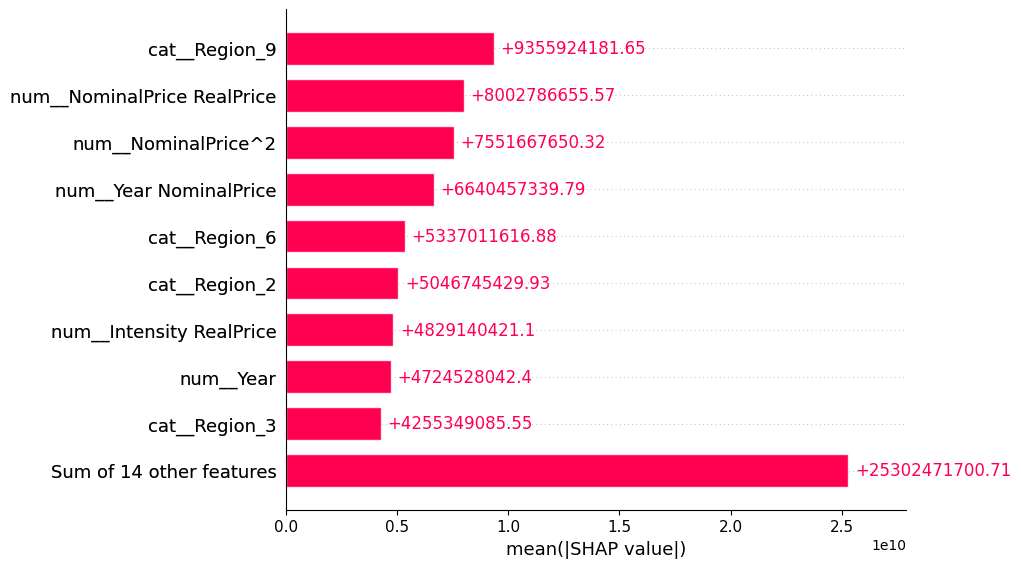

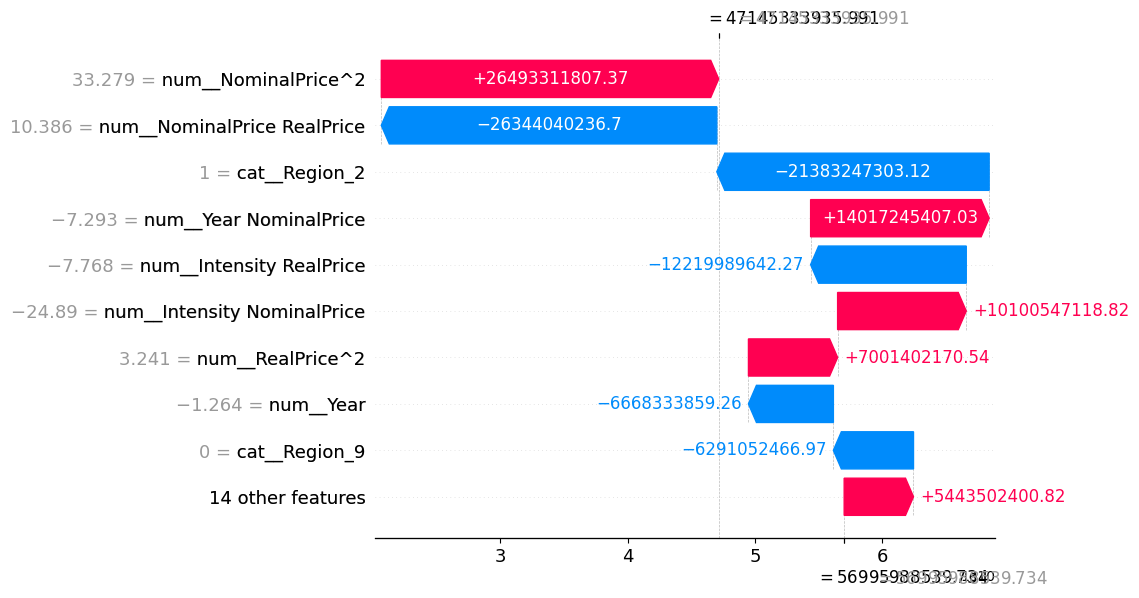

In [ ]:
# Summary beeswarm
shap.plots.beeswarm(shap_values_res)

# Bar plot
shap.plots.bar(shap_values_res)

# Waterfall plot untuk 1 sample
shap.plots.waterfall(shap_values_res[0])


# Kesimpulan

Penelitian ini bertujuan untuk memprediksi konsumsi listrik pada sektor residential dan industrial di Jepang periode 1990–2015 serta memahami faktor yang paling memengaruhi pola konsumsi tersebut. Data yang digunakan mencakup konsumsi listrik per wilayah, harga listrik (nominal dan riil), tahun, serta informasi region. Setelah melalui tahap eksplorasi data, validasi, serta pembersihan (Step 1–6), dilakukan konstruksi data, penentuan label, dan normalisasi sehingga data siap dipakai untuk pemodelan (Step 7–8).

Pada tahap pemodelan (Step 9), beberapa algoritma regresi diterapkan, mulai dari model linear sederhana (Linear Regression, Ridge, Lasso) hingga model non-linear yang lebih kompleks seperti Random Forest dan XGBoost. Hasil evaluasi awal menunjukkan bahwa model linear kurang mampu menangkap pola konsumsi listrik (R² rendah dan RMSE tinggi), sementara Random Forest dan XGBoost secara signifikan meningkatkan performa prediksi. Random Forest default bahkan memberikan RMSE yang relatif rendah (sekitar 0,9 miliar kWh untuk sektor residential dan 3,7 miliar kWh untuk sektor industrial) dengan R² di atas 0,99, sementara XGBoost default awalnya sedikit kalah, tetapi setelah dilakukan optimasi hyperparameter (Step 11) performa XGBoost meningkat dengan baik.

Evaluasi model (Step 10) menunjukkan bahwa penggunaan model non-linear mampu menjelaskan hampir seluruh variasi data (R² mendekati 1) dengan tingkat kesalahan prediksi yang cukup rendah (dalam kisaran miliar kWh), yang dapat diterima untuk analisis makro konsumsi energi. Optimasi hyperparameter pada Random Forest dan XGBoost menurunkan RMSE dan meningkatkan R², menunjukkan bahwa tuning model memberikan dampak nyata terhadap akurasi prediksi.

Tahap interpretasi (Step 12) menggunakan analisis feature importance dan SHAP values mengungkap bahwa variabel Region mendominasi kontribusi prediksi baik di sektor residential maupun industrial, sementara variabel harga (nominal maupun riil) dan tahun memiliki pengaruh yang sangat kecil. Hal ini menunjukkan bahwa perbedaan geografis (seperti kepadatan penduduk, iklim, dan struktur industri per wilayah) menjadi faktor utama dalam variasi konsumsi listrik, sedangkan harga listrik tampaknya tidak terlalu memengaruhi permintaan, mencerminkan sifat kebutuhan listrik sebagai kebutuhan inelastis.

Secara keseluruhan, eksperimen ini berhasil membangun model prediksi konsumsi listrik yang akurat sekaligus memberikan wawasan bahwa kebijakan pengelolaan konsumsi listrik di Jepang sebaiknya disesuaikan secara spesifik per wilayah, karena faktor regional jauh lebih berpengaruh dibandingkan harga listrik atau tren tahunan.